In [1]:
import itertools 
import math
import os
import pickle as pkl
from typing import List, Dict, Any

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import fetch_openml

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250

%load_ext autoreload
%autoreload 2

# change working directory to project root
if os.getcwd().split('/')[-1] != 'imodels':
    os.chdir('..')

MODEL_COMPARISON_PATH = 'tests/comparison_data/'

In [2]:
datasets = [
        ("breast-cancer", 13),
        ("breast-w", 15),
        ("credit-g", 31),
        ("haberman", 43),
        ("heart", 1574),
        ("labor", 4),
        ("vote", 56),
    ]

def get_comparison_result(path: str, estimator_name: str, test=False) -> Dict[str, Any]:
    if test:
        result_file = path + 'test/' + f'{estimator_name}_test_comparisons.pkl'
    else:
        result_file = path + 'val/' + f'{estimator_name}_comparisons.pkl'
    return pkl.load(open(result_file, 'rb'))

def get_x_and_y(result_data: pd.Series) -> (pd.Series, pd.Series):
    complexities = result_data[result_data.index.str.contains('complexity')]
    rocs = result_data[result_data.index.str.contains('ROC')]
    complexity_sort_indices = complexities.argsort()    
    return complexities[complexity_sort_indices], rocs[complexity_sort_indices]

def viz_comparison_val_average(result: Dict[str, Any]) -> None:
    '''Plot dataset-averaged ROC AUC vs dataset-averaged complexity for different hyperparameter settings
    of a single model, including zoomed-in plot of overlapping region
    '''
    result_data = result['df']['mean']
    result_estimators = result['estimators']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    for est in np.unique(result_estimators):
        
        est_result_data = result_data[result_data.index.str.contains(est)]
        x, y = get_x_and_y(est_result_data)  
        axes[0].plot(x, y, marker='o', markersize=4, label=est.replace('_', ' '))
        
        if est in result['auc_of_auc'].index:
            area = result['auc_of_auc'][est]
            label = est.split(' - ')[1] + f' AUC: {area:.3f}'
            axes[1].plot(x, y, marker='o', markersize=4, label=label.replace('_', ' '))

    for ax in axes:
        ax.set_xlabel('complexity score')
        ax.set_ylabel('ROC AUC')
        ax.legend(frameon=False, handlelength=1) 
    axes[0].set_title('average ROC AUC across all comparison datasets')
    axes[1].set_xlim(result['auc_of_auc_lb'], result['auc_of_auc_ub'])
    axes[1].set_title('Overlapping, low (<30) complexity region only')
    
    plt.tight_layout()
    plt.show()

def viz_comparison_test_average(results: List[Dict[str, Any]]) -> None:
    '''Plot dataset-averaged ROC AUC vs dataset-averaged complexity for different models
    '''
    for result in results:
        mean_result = result['df']['mean']
        est = result['estimators'][0]
        x, y = get_x_and_y(mean_result)  
        plt.plot(x, y, marker='o', markersize=2, linewidth=1, label=est.replace('_', ' '))
    plt.xlim(0, 30)
    plt.xlabel('complexity score', size=8)
    plt.ylabel('ROC AUC', size=8)
    plt.title('average ROC AUC across all comparison datasets', size=8)
    plt.legend(frameon=False, handlelength=1, fontsize=8)
    plt.show()

def viz_comparison_datasets(result: Dict[str, Any], cols=3, figsize=(14, 10), test=False) -> None:
    '''Plot ROC AUC vs complexity for different datasets and models (not averaged)
    '''
    if test:
        results_df = pd.concat([r['df'] for r in result])
        results_estimators = [r['estimators'][0] for r in result]
    else:
        results_df = result['df']
        results_estimators = np.unique(result['estimators'])

    datasets = list(results_df.columns)[:-2]
    n_rows = int(math.ceil(len(datasets) / cols))
    fig, axes = plt.subplots(n_rows, cols, figsize=figsize)

    for i, dataset in enumerate(datasets):
        curr_ax = axes[i // cols, i % cols]
        results_data = results_df[dataset]
        for est in np.unique(results_estimators):
            results_data_est = results_data[results_data.index.str.contains(est)]
            x, y = get_x_and_y(results_data_est)
            curr_ax.plot(x, y, marker='o', markersize=4, label=est.replace('_', ' '))
        
        curr_ax.set_xlim(0, 30)
        curr_ax.set_xlabel('complexity score')
        curr_ax.set_ylabel('ROC AUC')
        curr_ax.set_title(f'dataset {dataset}')
        curr_ax.legend(frameon=False, handlelength=1)
    
    plt.tight_layout()
    plt.show()

# dataset stats

In [3]:
metadata = []
columns = ['name', 'samples', 'features', 'class 0 ct', 'class 1 ct', 'majority class %']
for dataset_name, data_id in datasets:
    dataset = fetch_openml(data_id=data_id, as_frame=False)
    shape = dataset.data.shape
    class_counts = np.unique(dataset.target, return_counts=True)[1]
    metadata.append([dataset_name, shape[0], shape[1], class_counts[0], class_counts[1], np.max(class_counts) / np.sum(class_counts)])
pd.DataFrame(metadata, columns=columns).set_index('name') 

samples  features  class 0 ct  class 1 ct  majority class %
name                                                                      
breast-cancer      286         9         201          85          0.702797
breast-w           699         9         458         241          0.655222
credit-g          1000        20         300         700          0.700000
haberman           306         3         225          81          0.735294
heart              270        13         150         120          0.555556
labor               57        16          20          37          0.649123
vote               435        16         267         168          0.613793

# complexity vs. ROC Area plot for all models

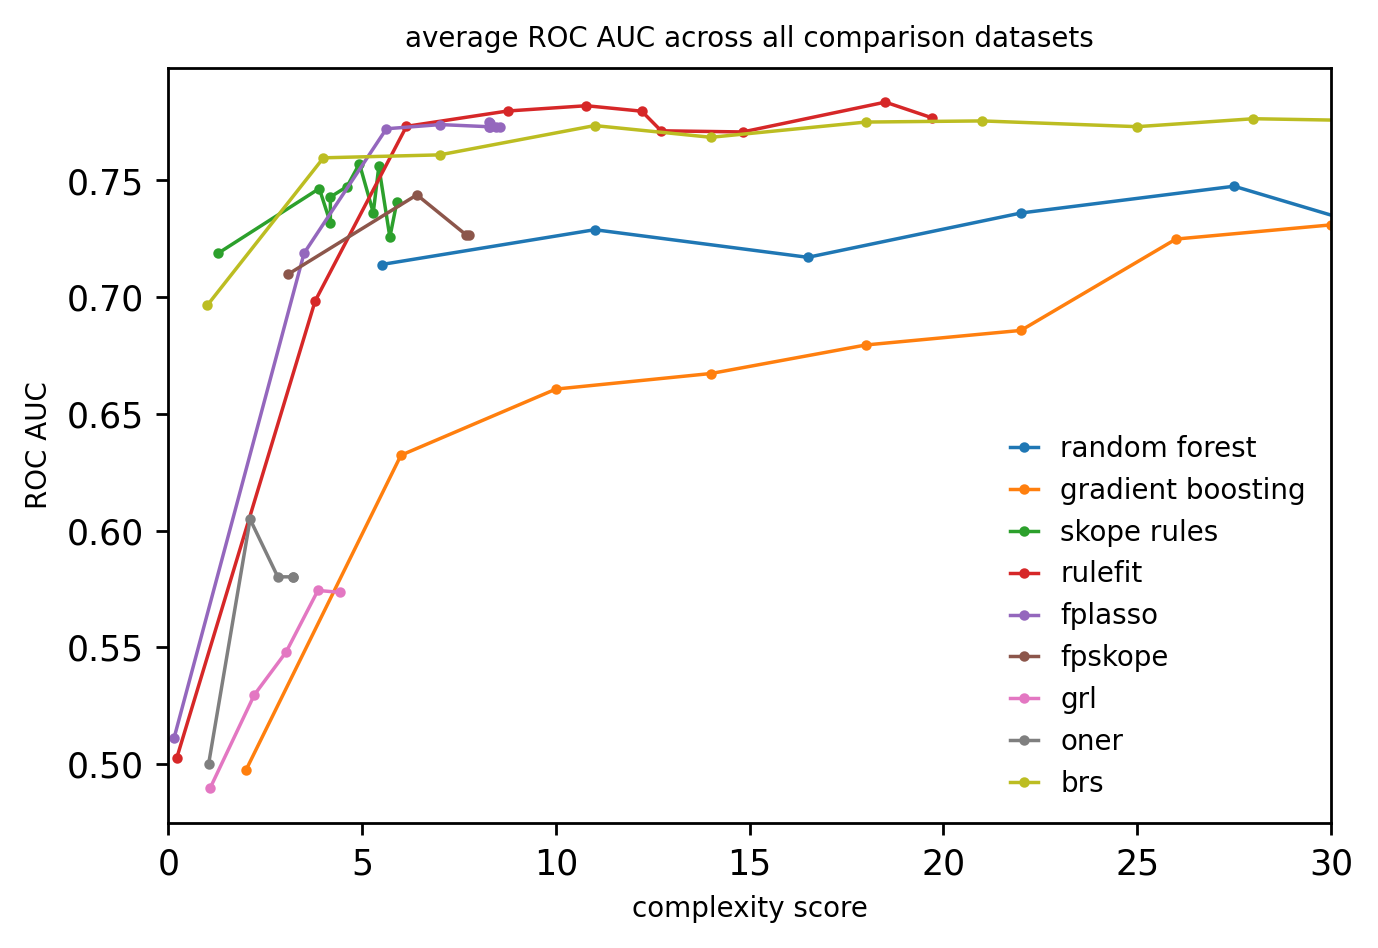

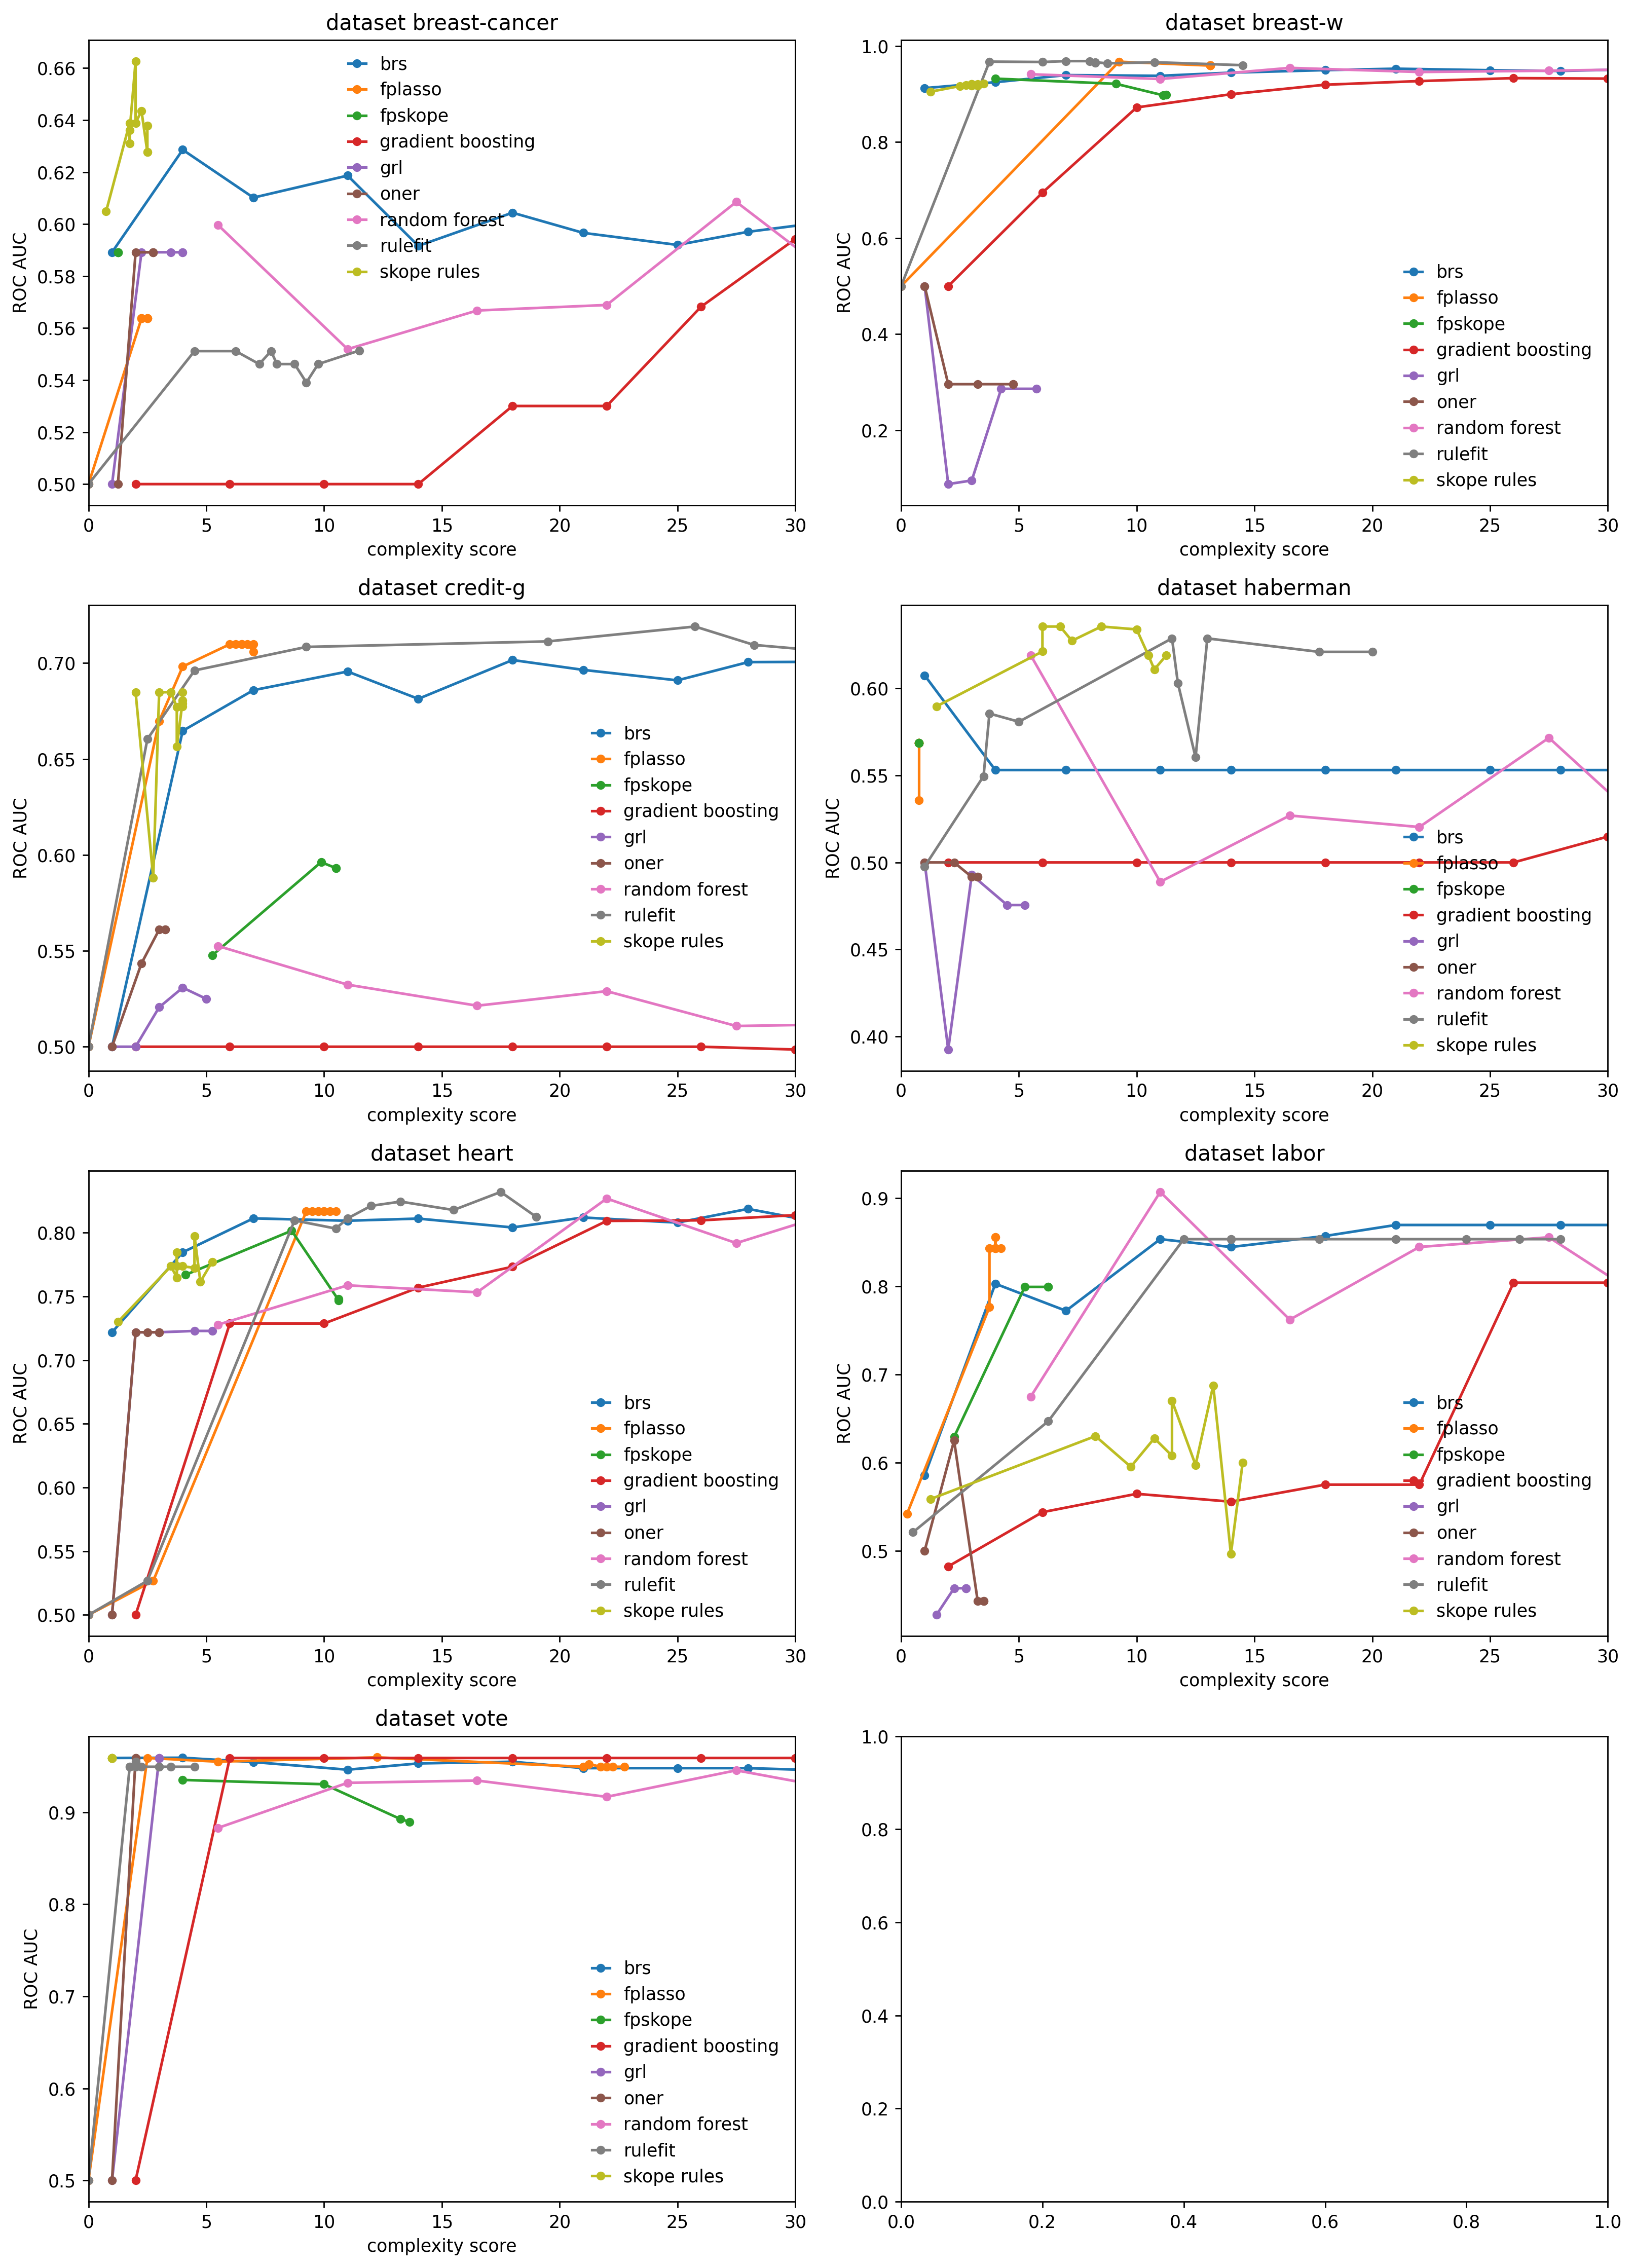

In [4]:
test_models = [
    'random_forest', 
    'gradient_boosting', 
    'skope_rules', 
    'rulefit', 
    'fplasso', 
    'fpskope',
    'grl',
    'oner',
    'brs']
test_results = [get_comparison_result(MODEL_COMPARISON_PATH, mname, test=True) for mname in test_models]
viz_comparison_test_average(test_results)
viz_comparison_datasets(test_results, cols=2, figsize=(13, 18), test=True)

# hyperparameter tuning plots for each model


## Random Forest

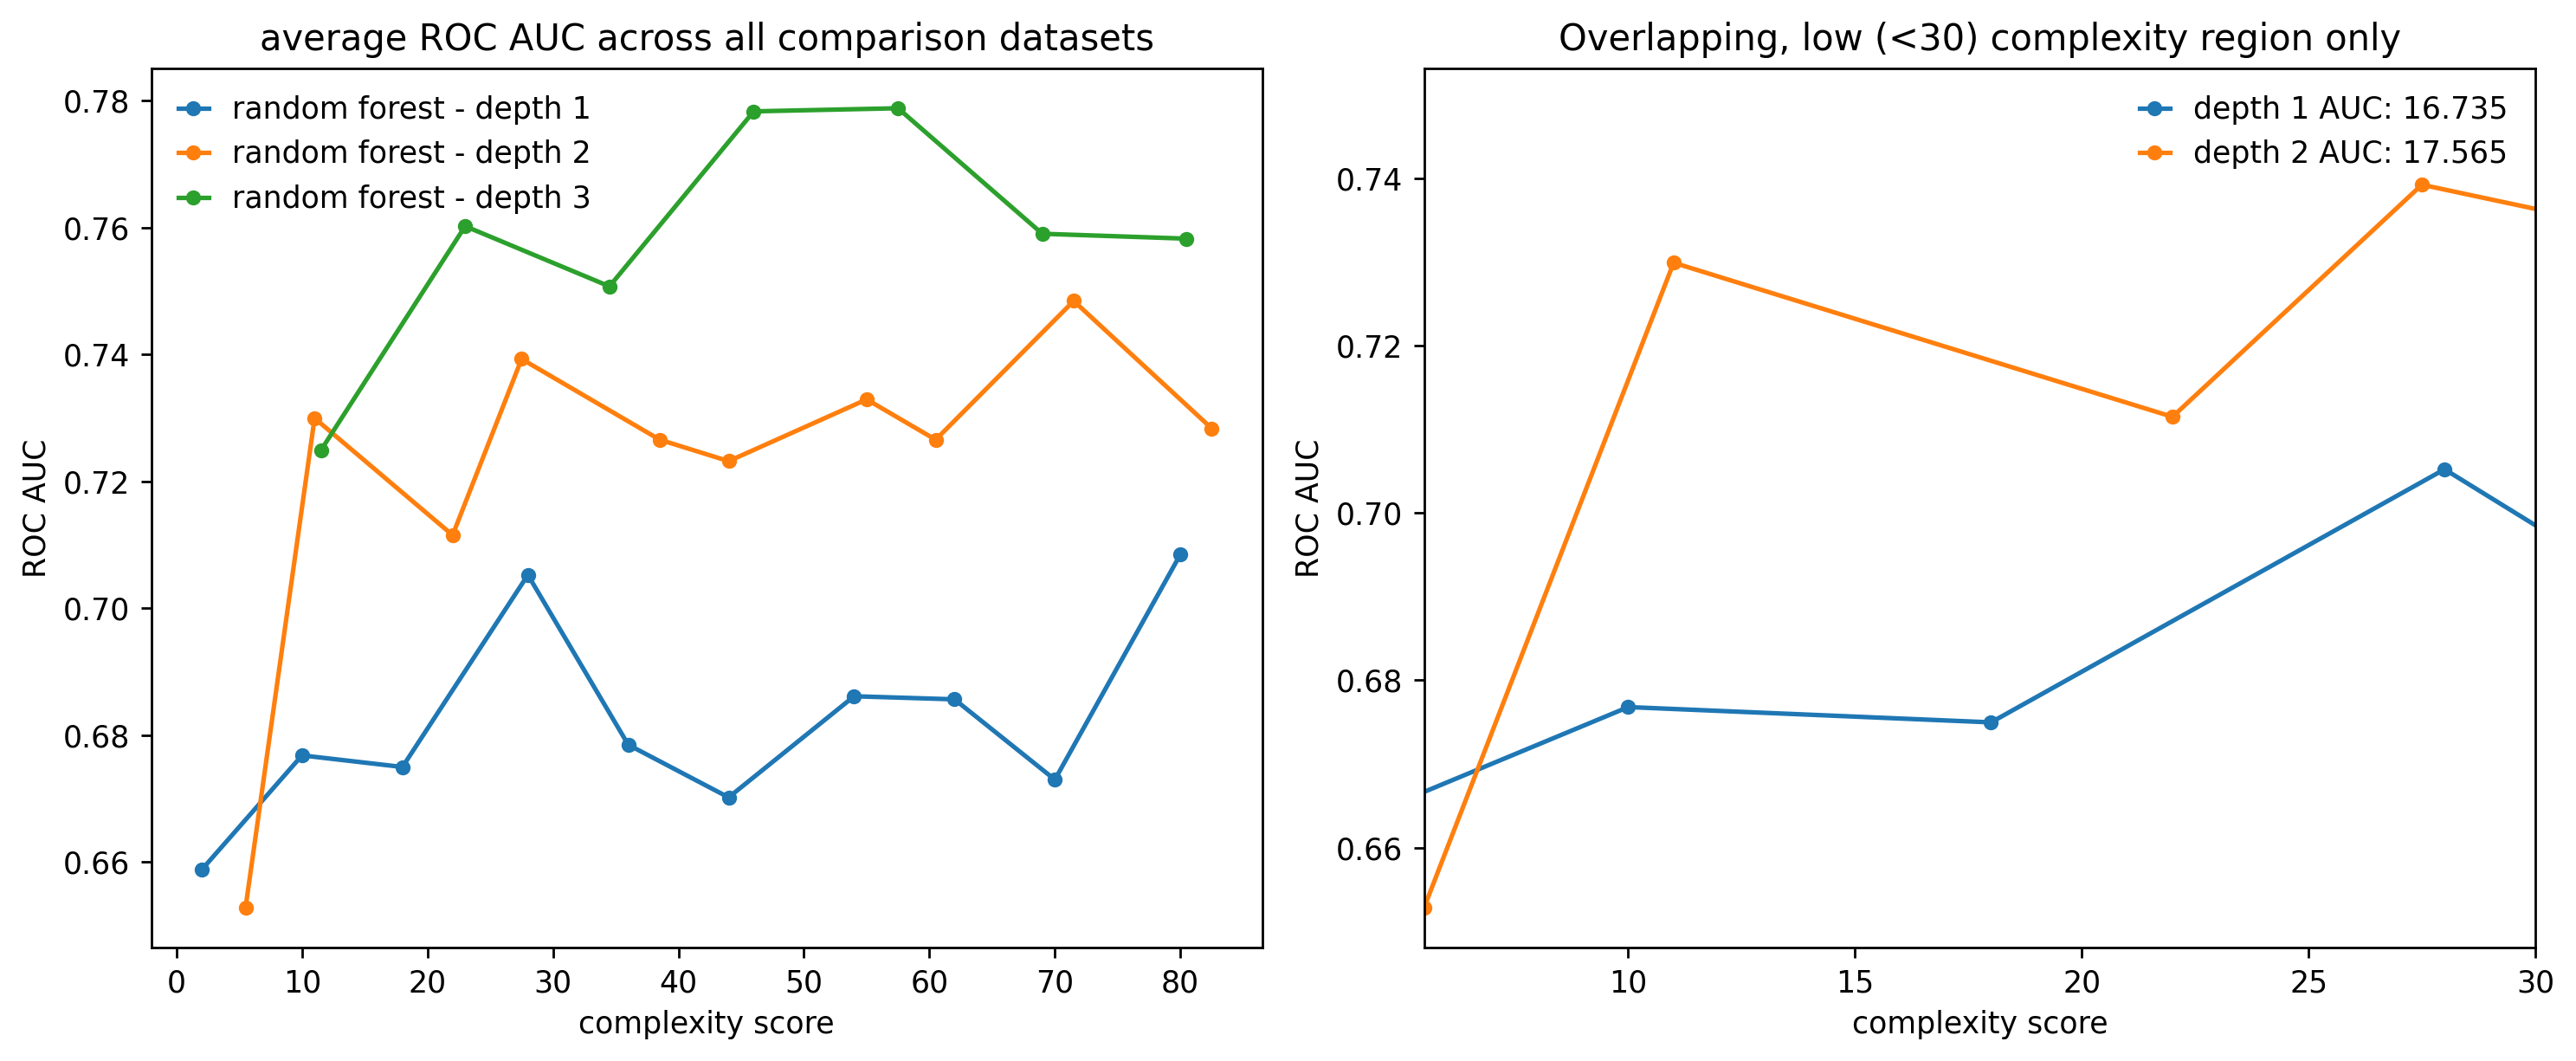

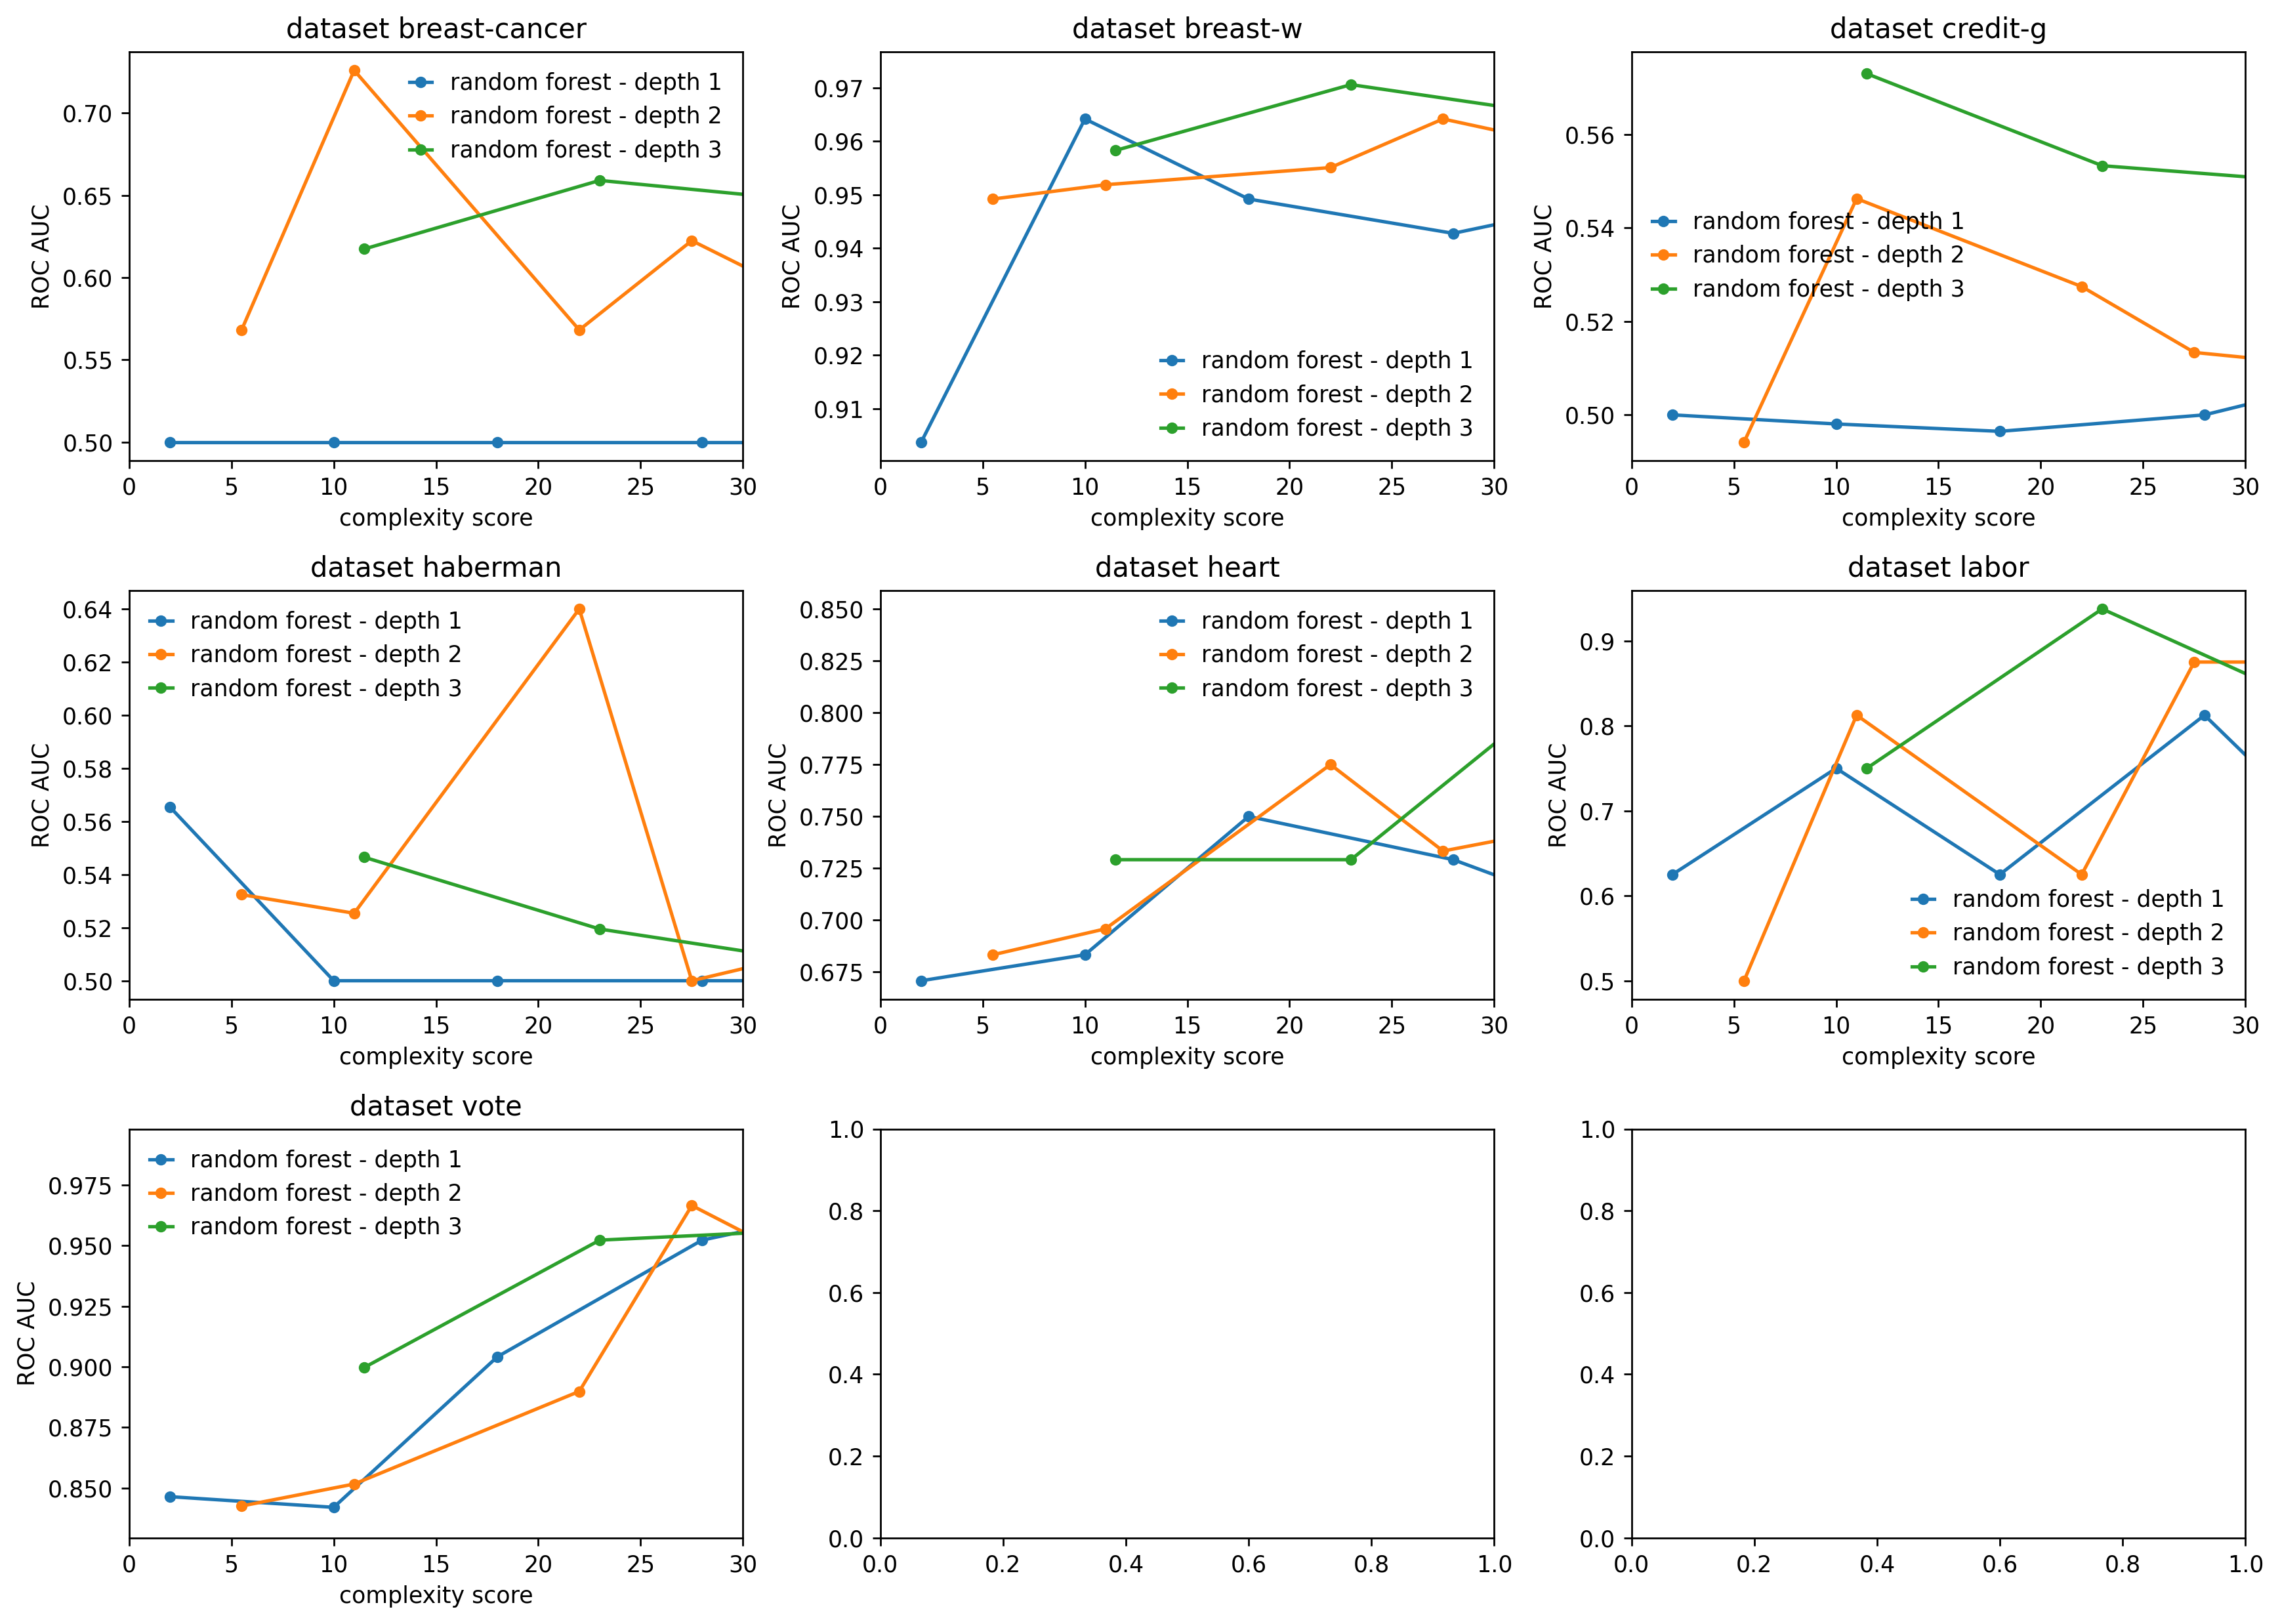

In [5]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'random_forest')
viz_comparison_val_average(comparison_result)
viz_comparison_datasets(comparison_result)

## Gradient boosted trees

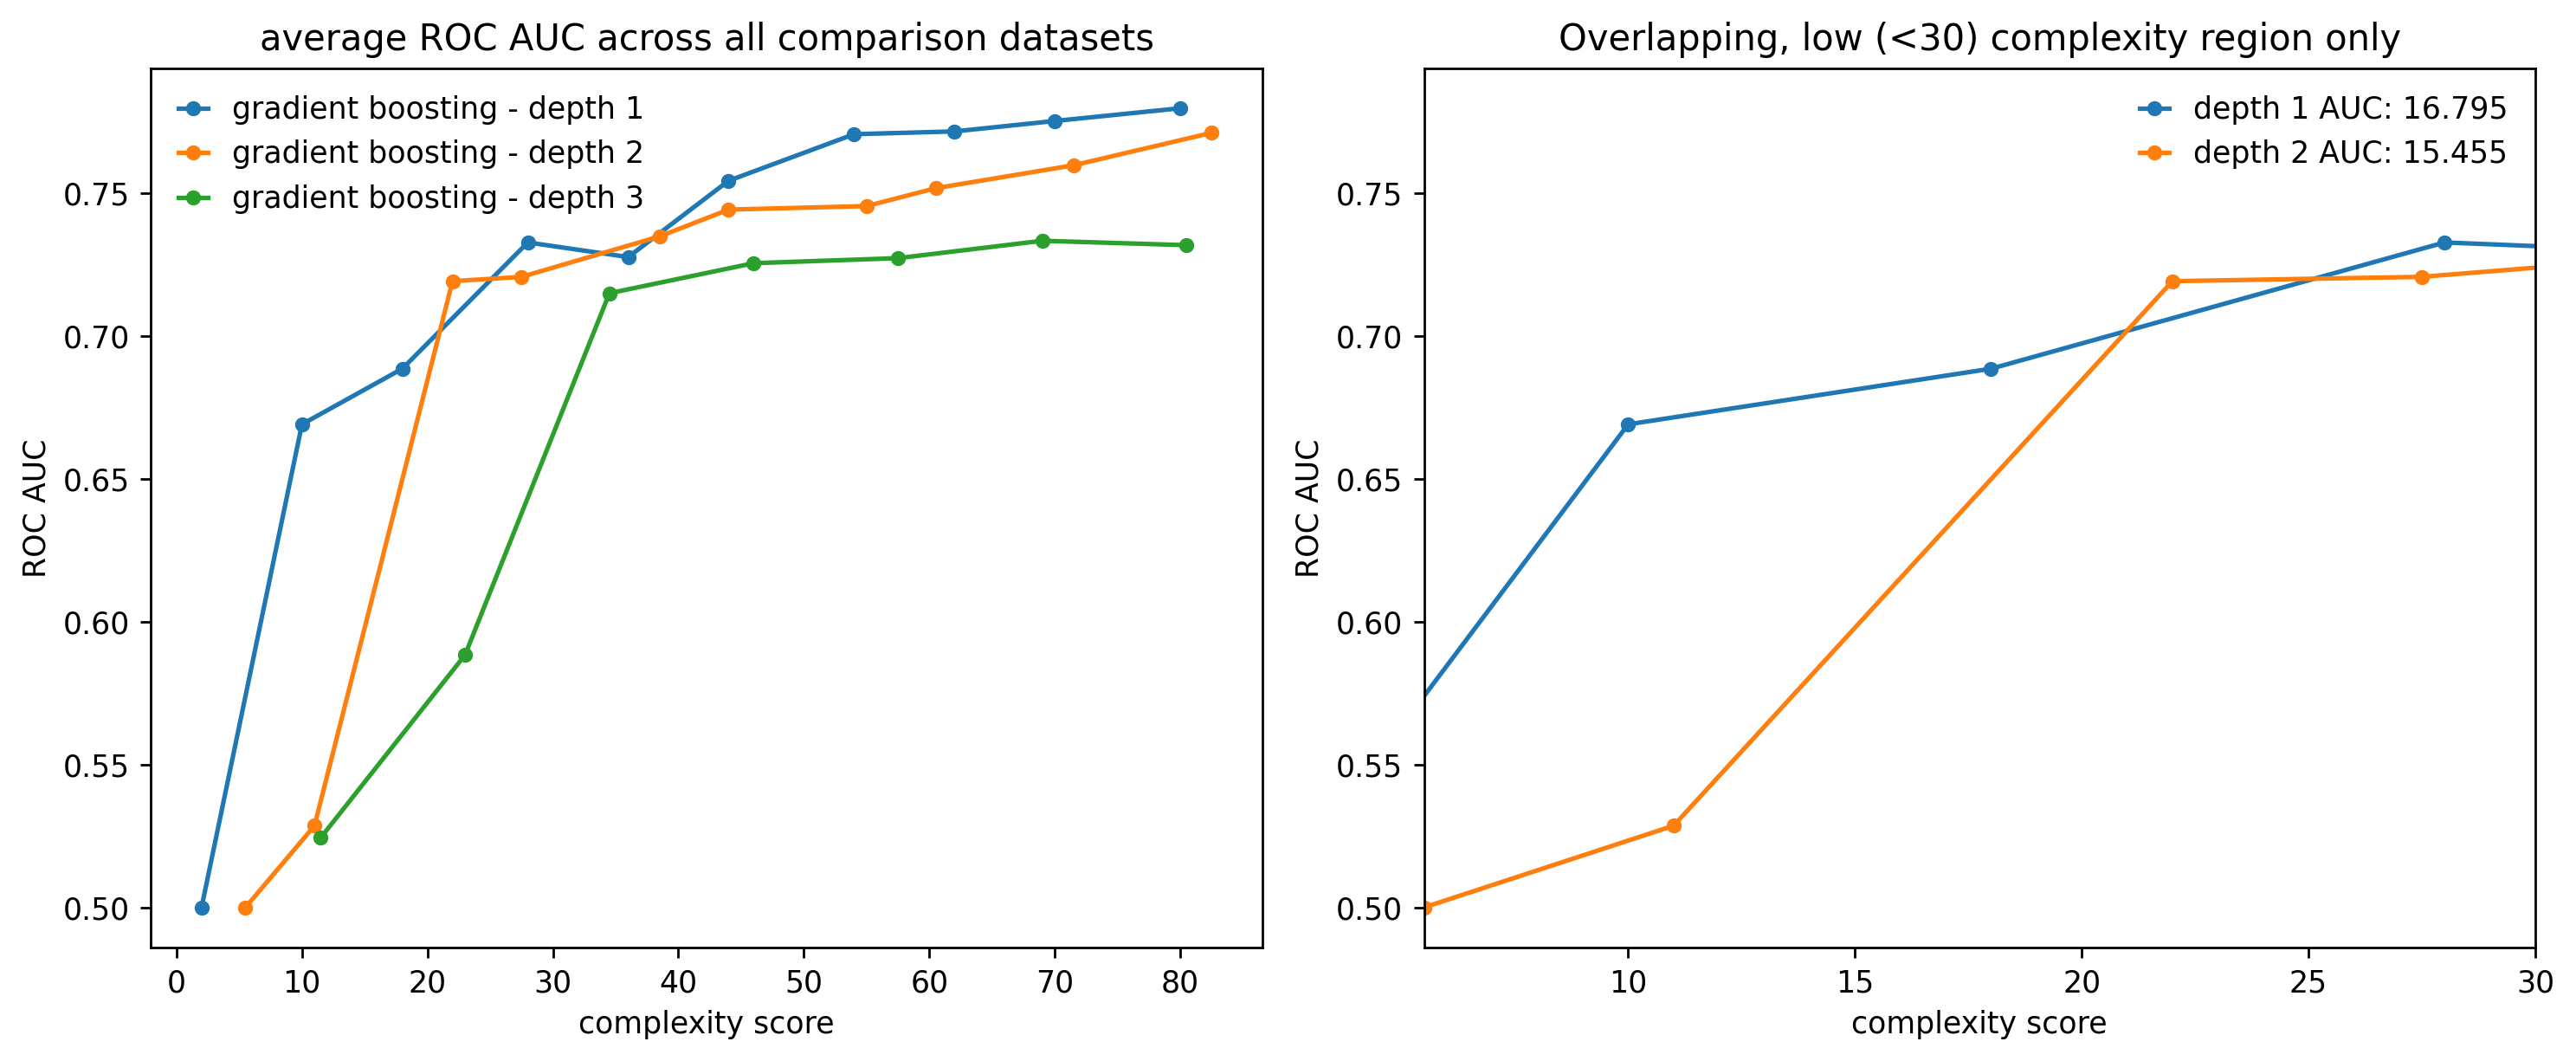

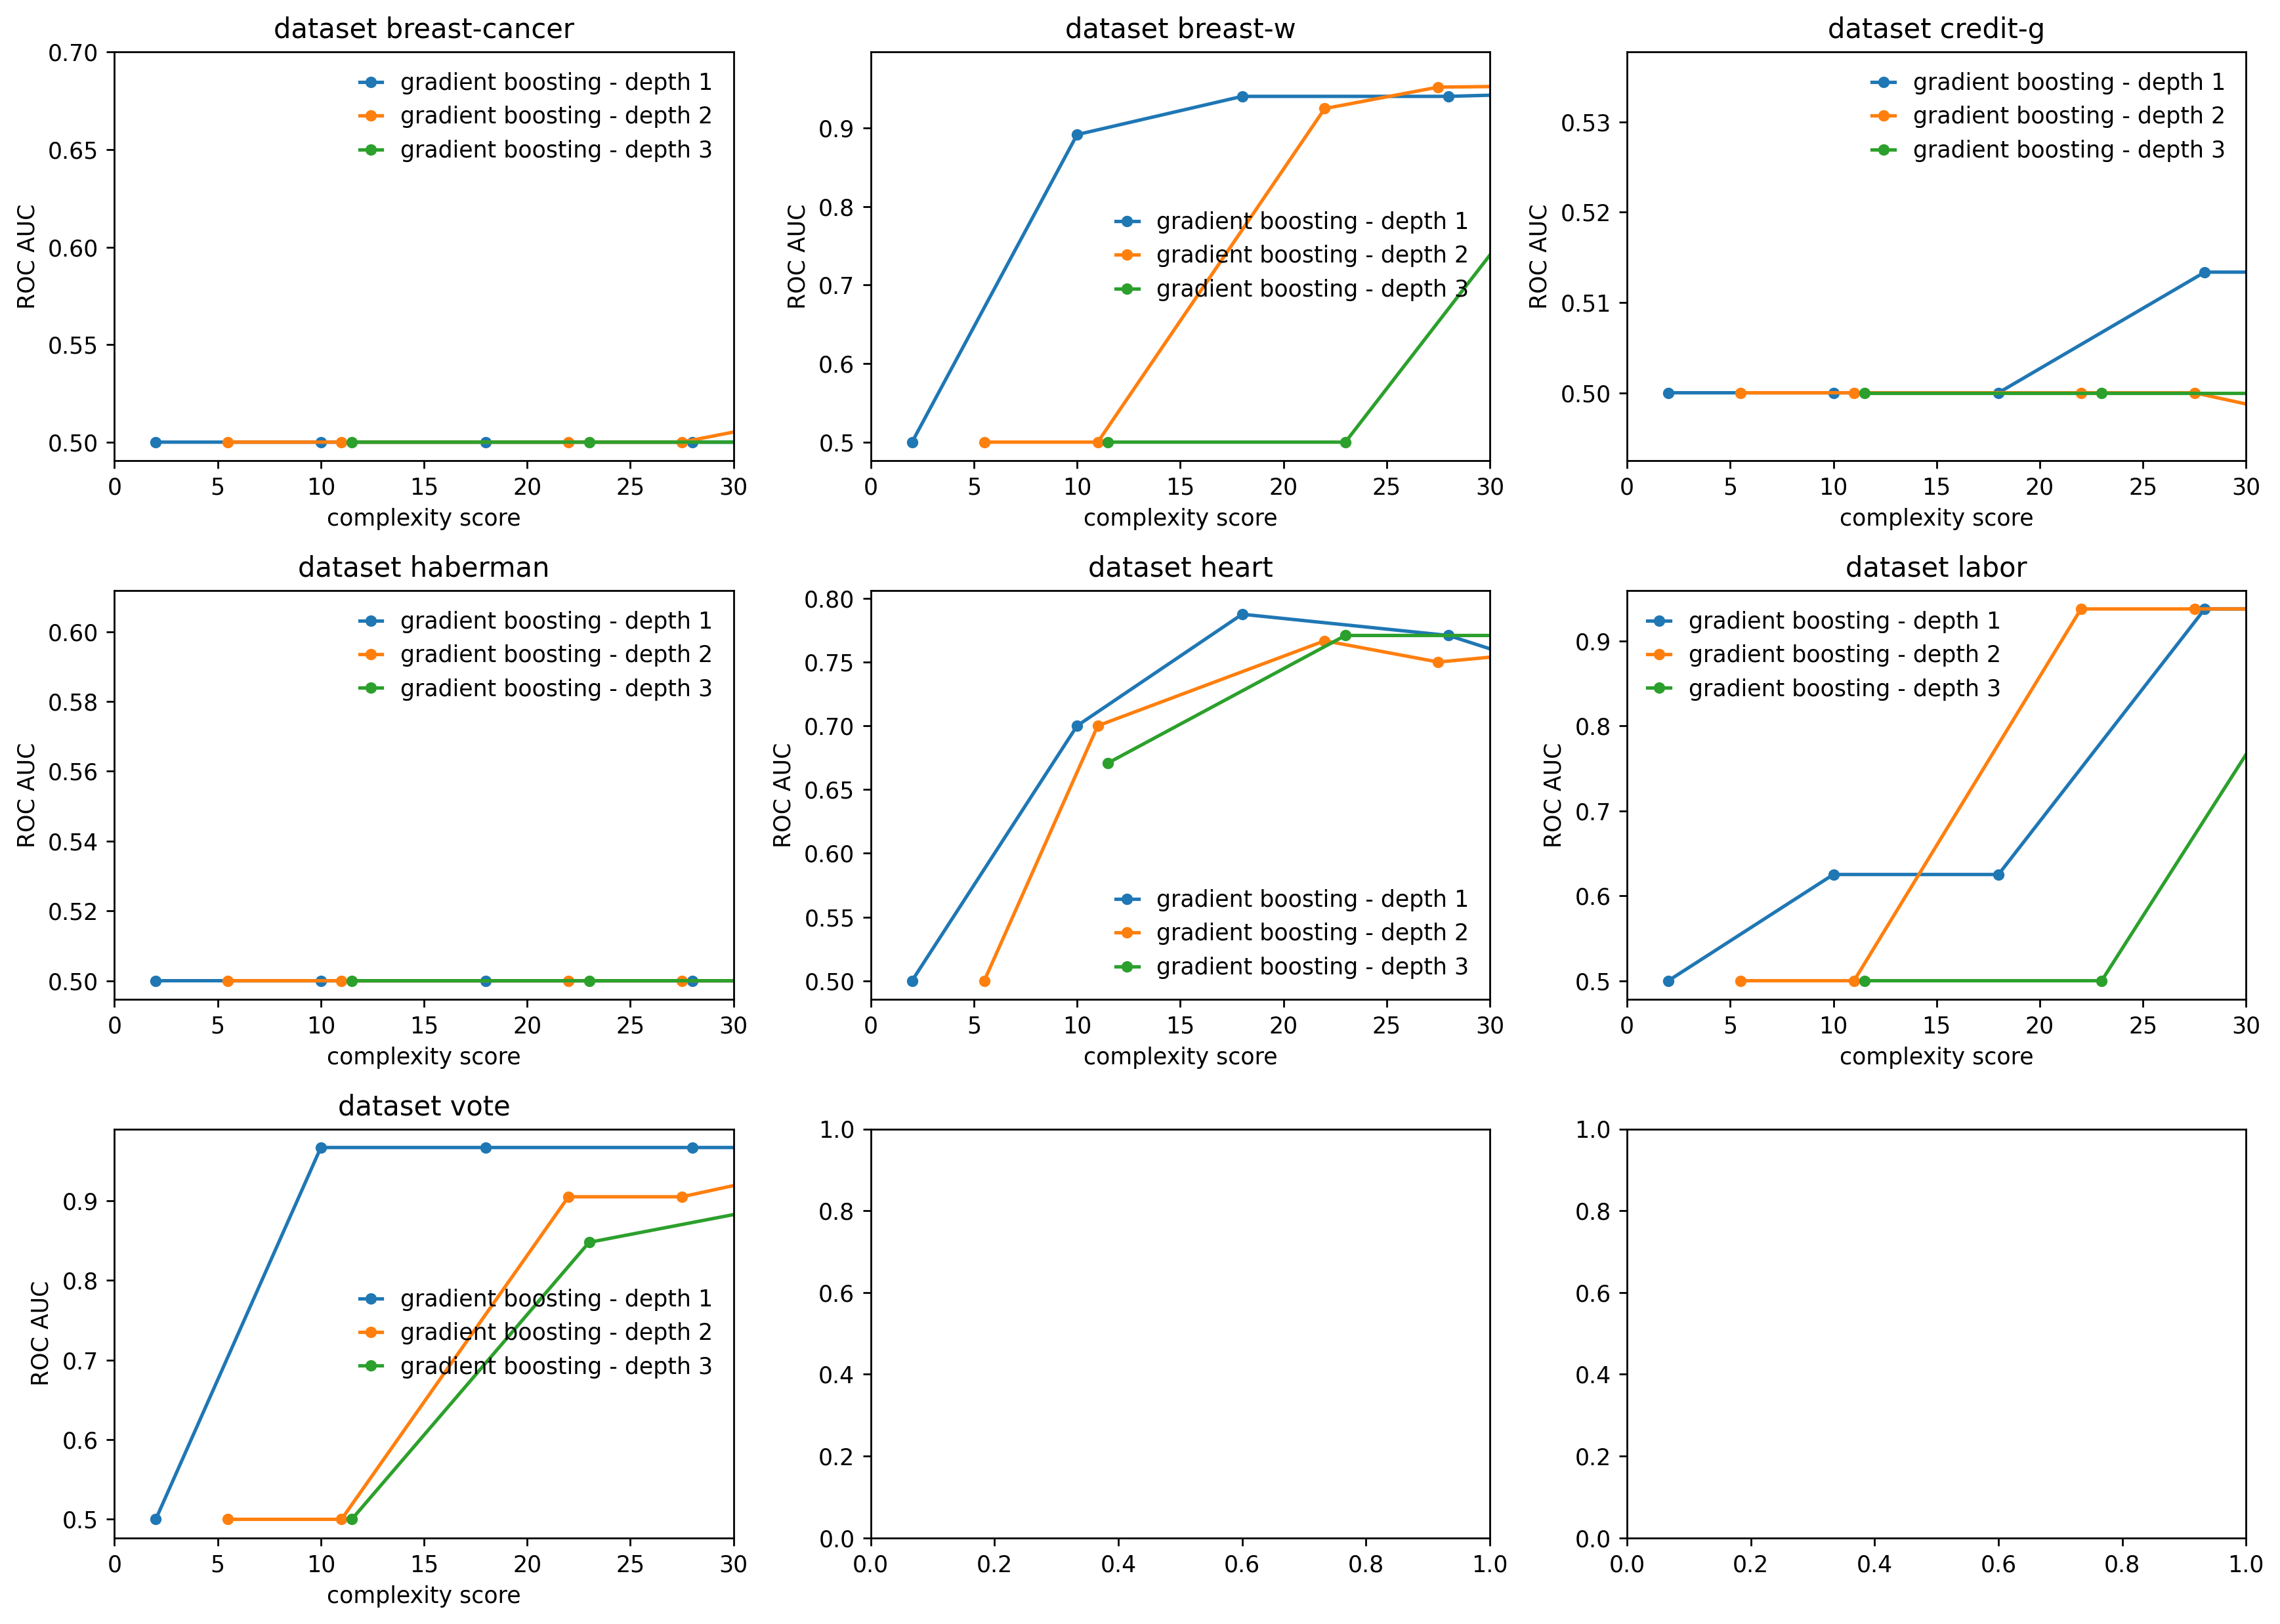

In [6]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'gradient_boosting')
viz_comparison_val_average(comparison_result)
viz_comparison_datasets(comparison_result)

## SkopeRules

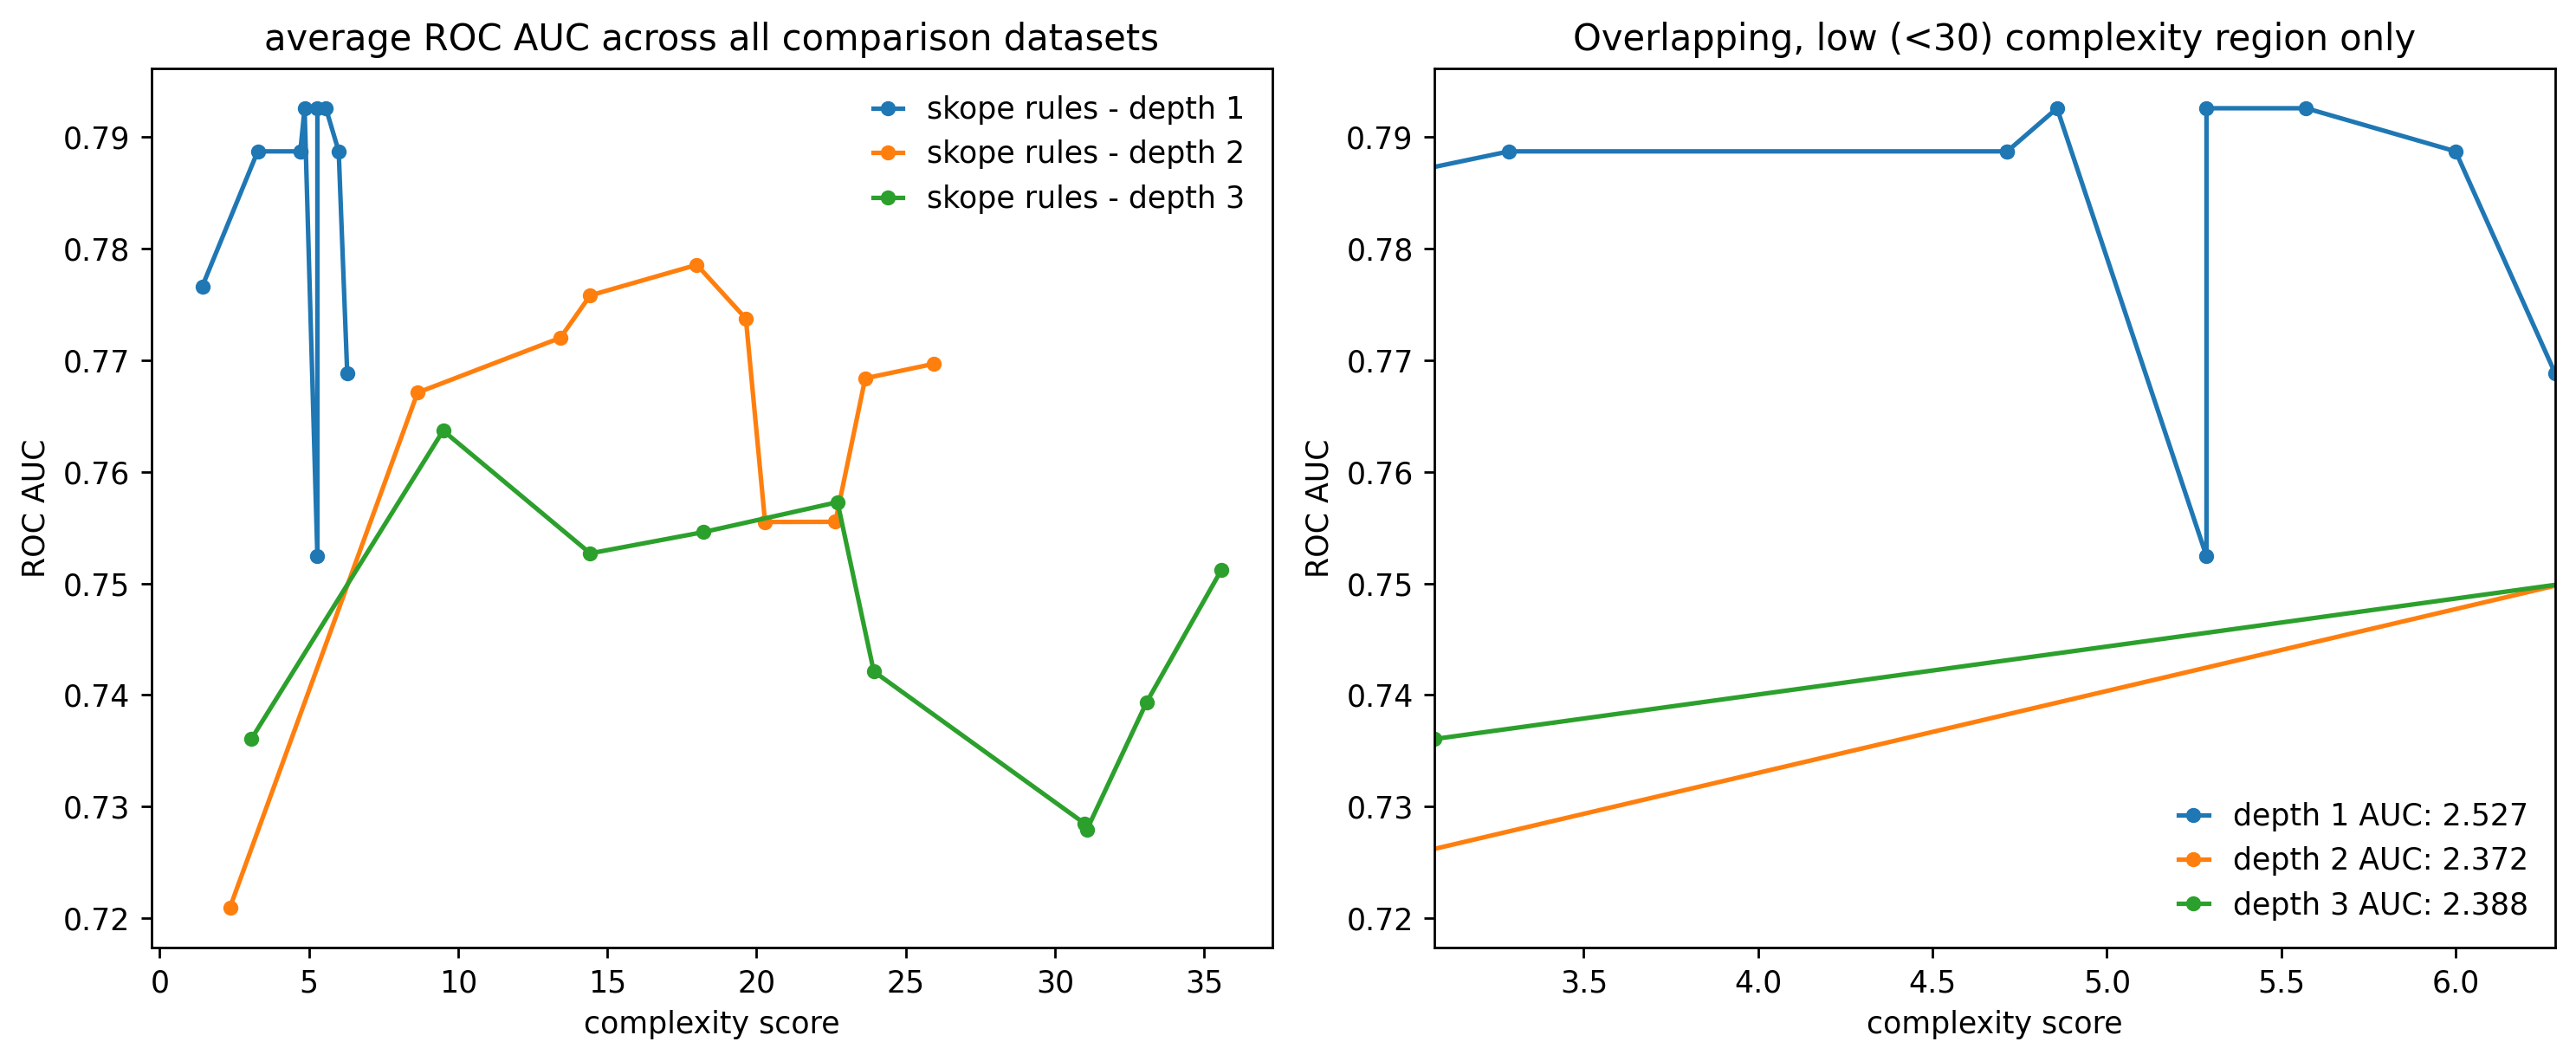

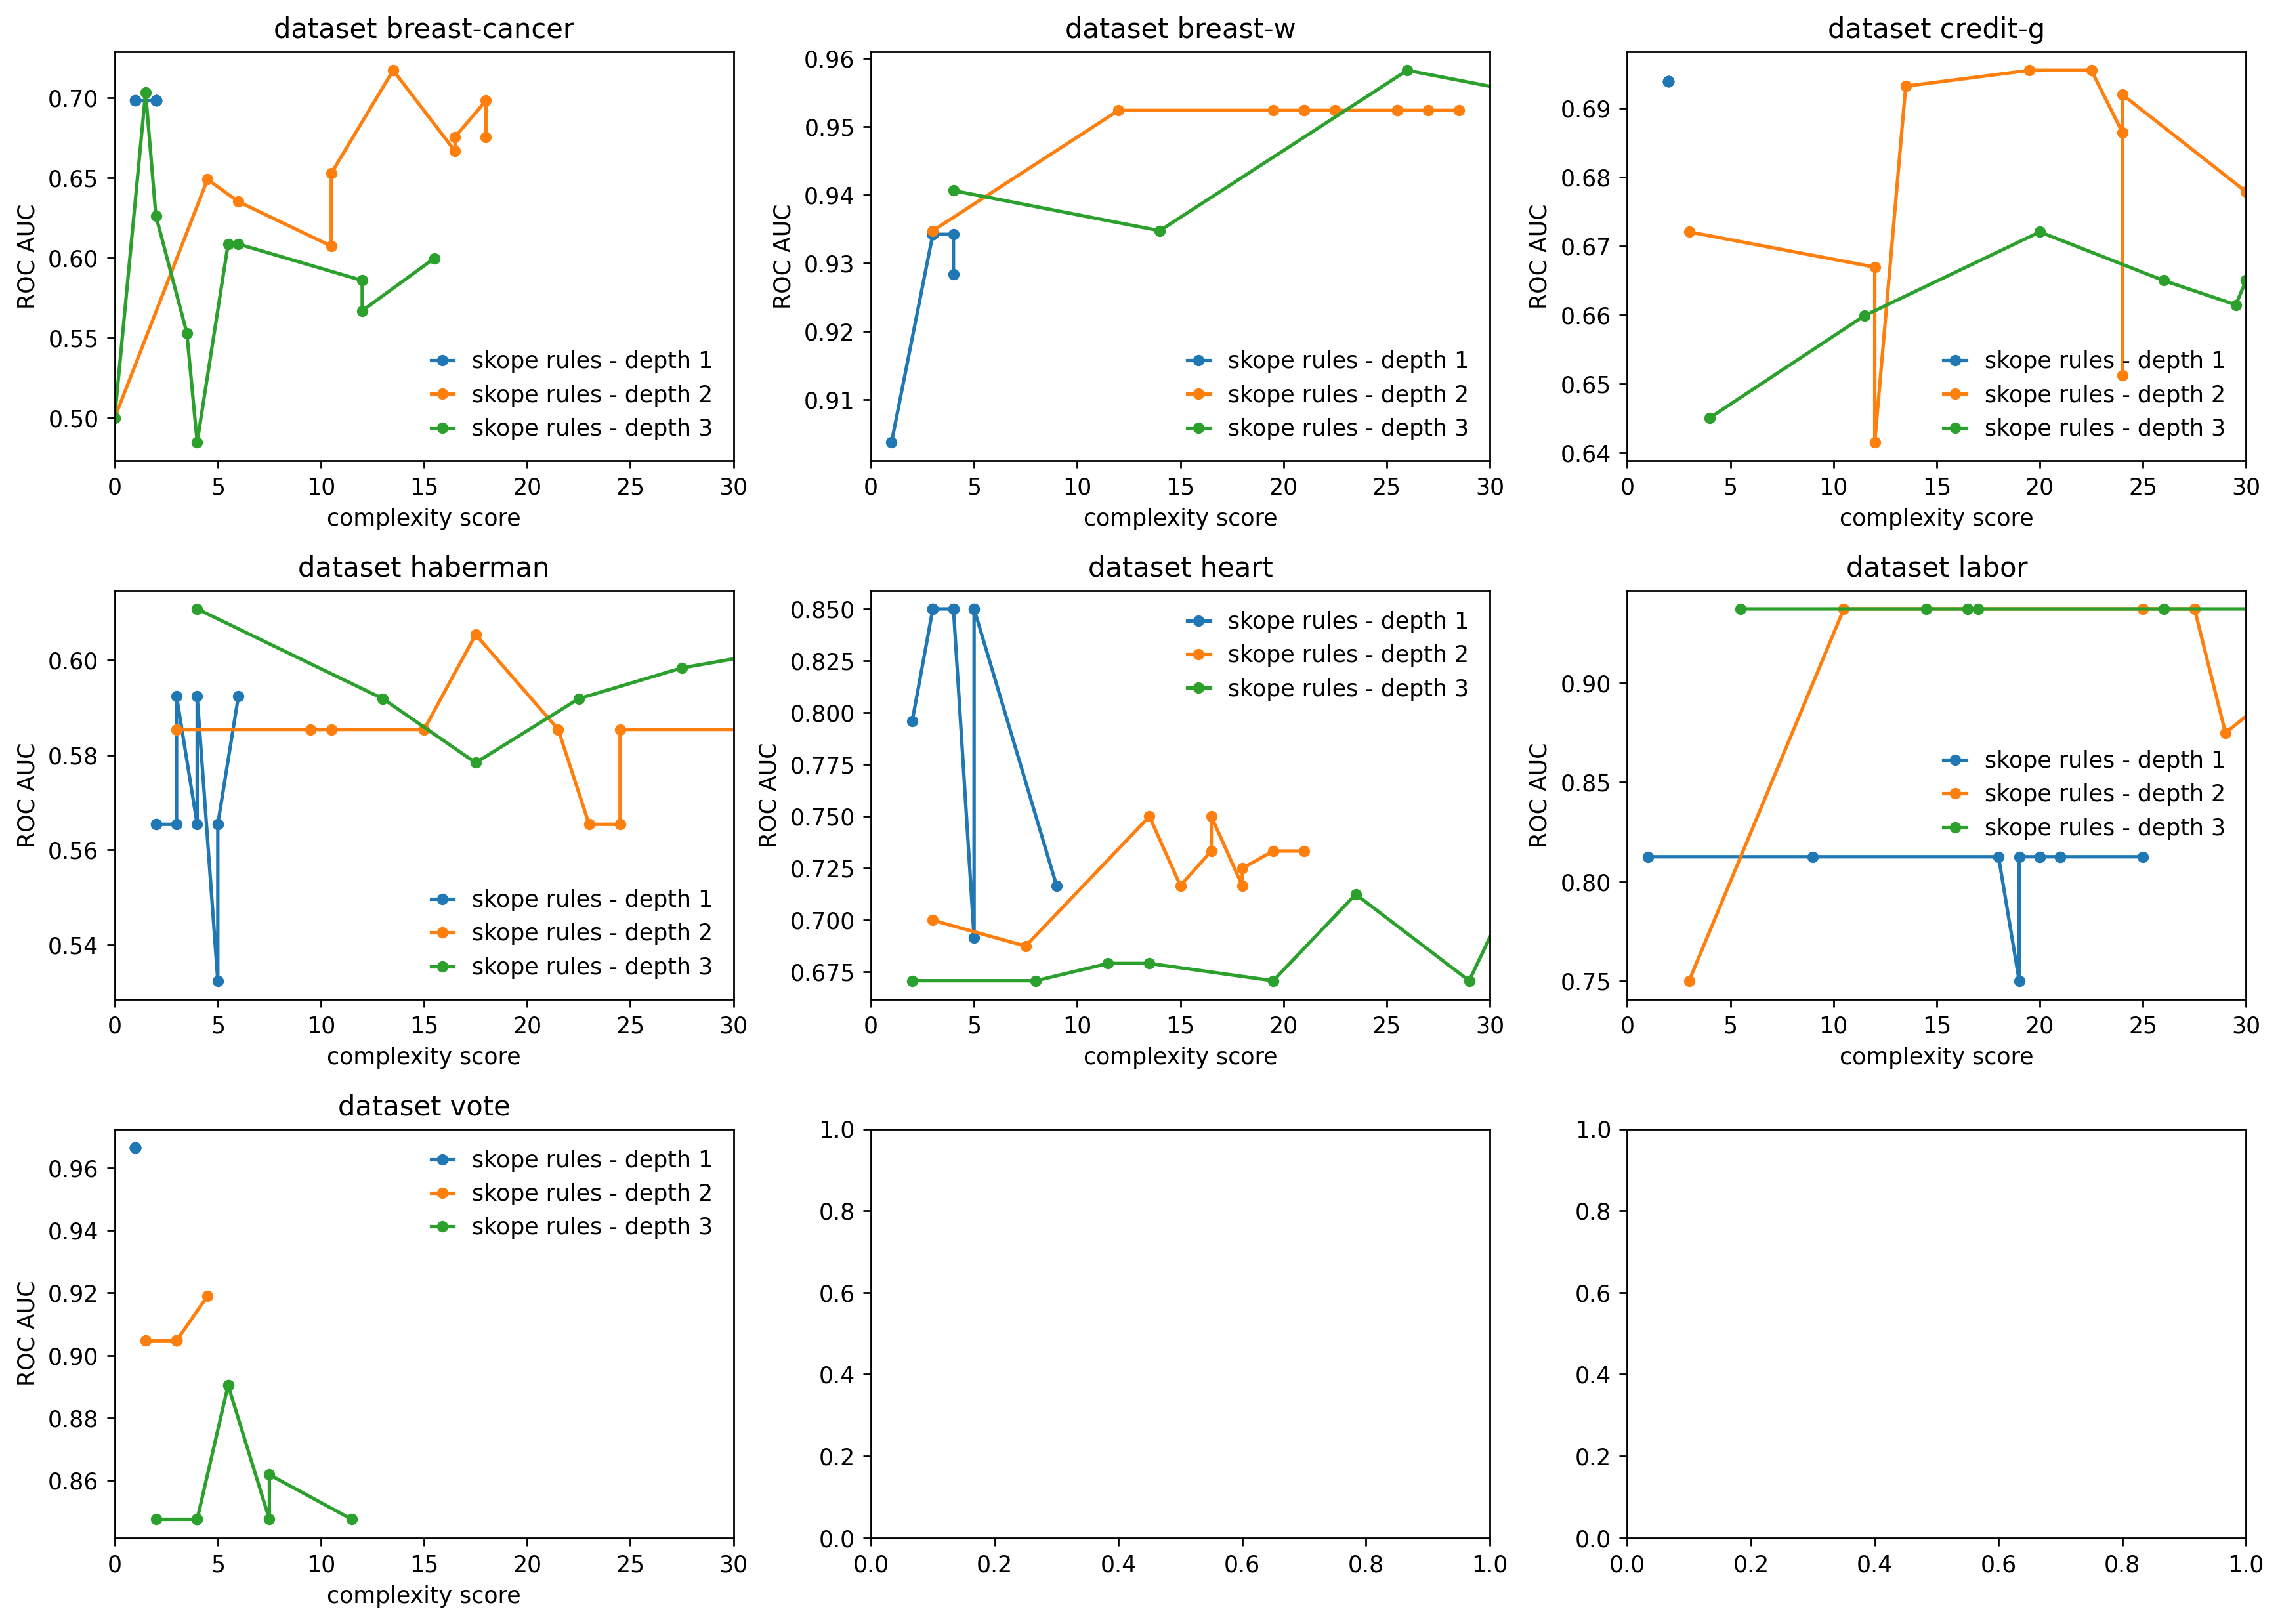

In [7]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'skope_rules')
viz_comparison_val_average(comparison_result)
viz_comparison_datasets(comparison_result)

## RuleFit

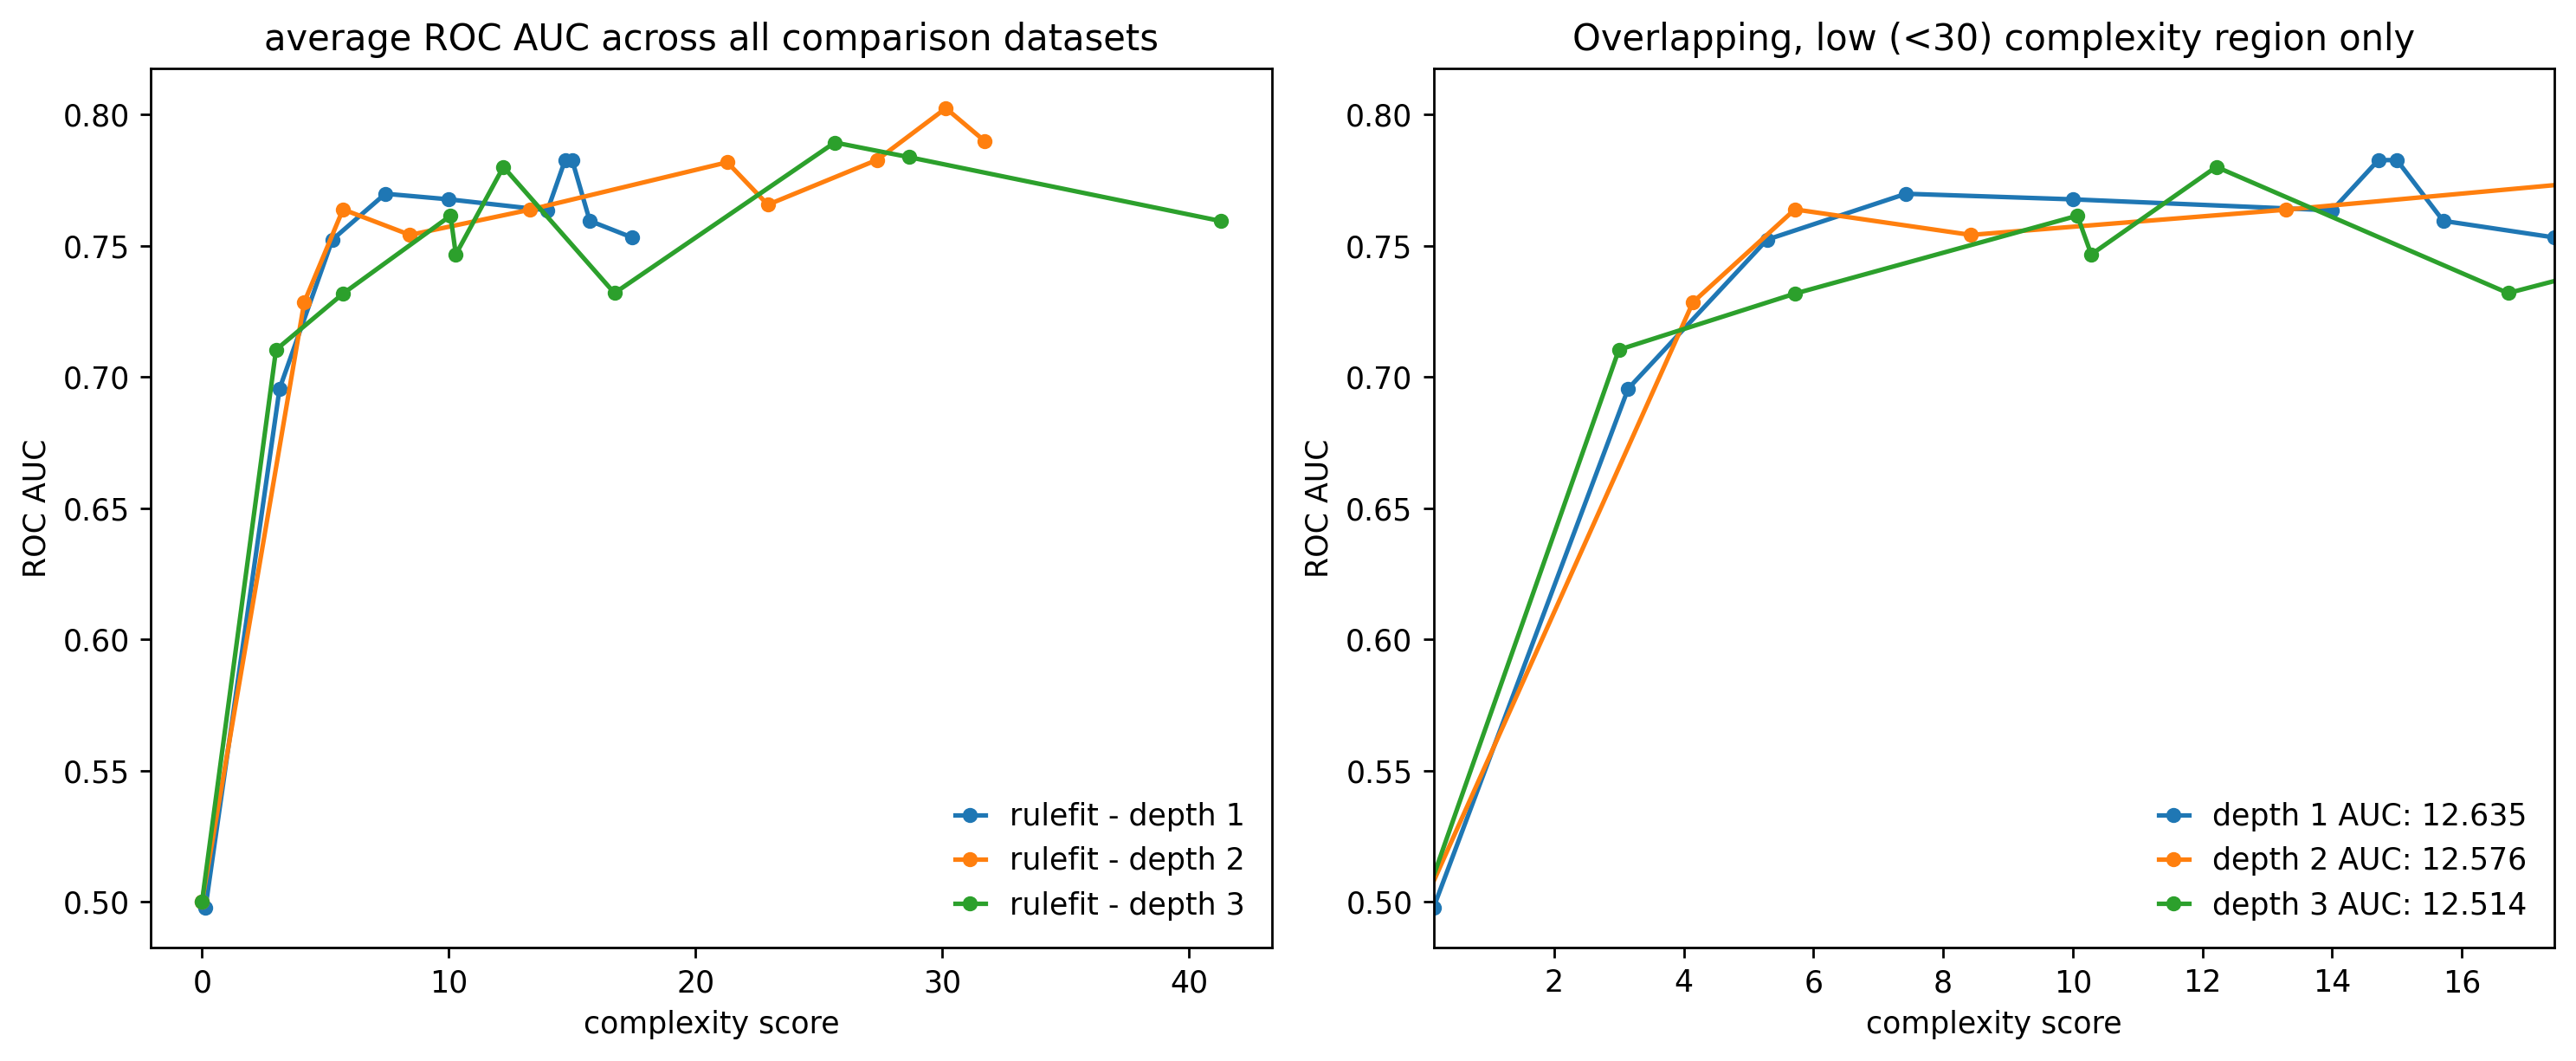

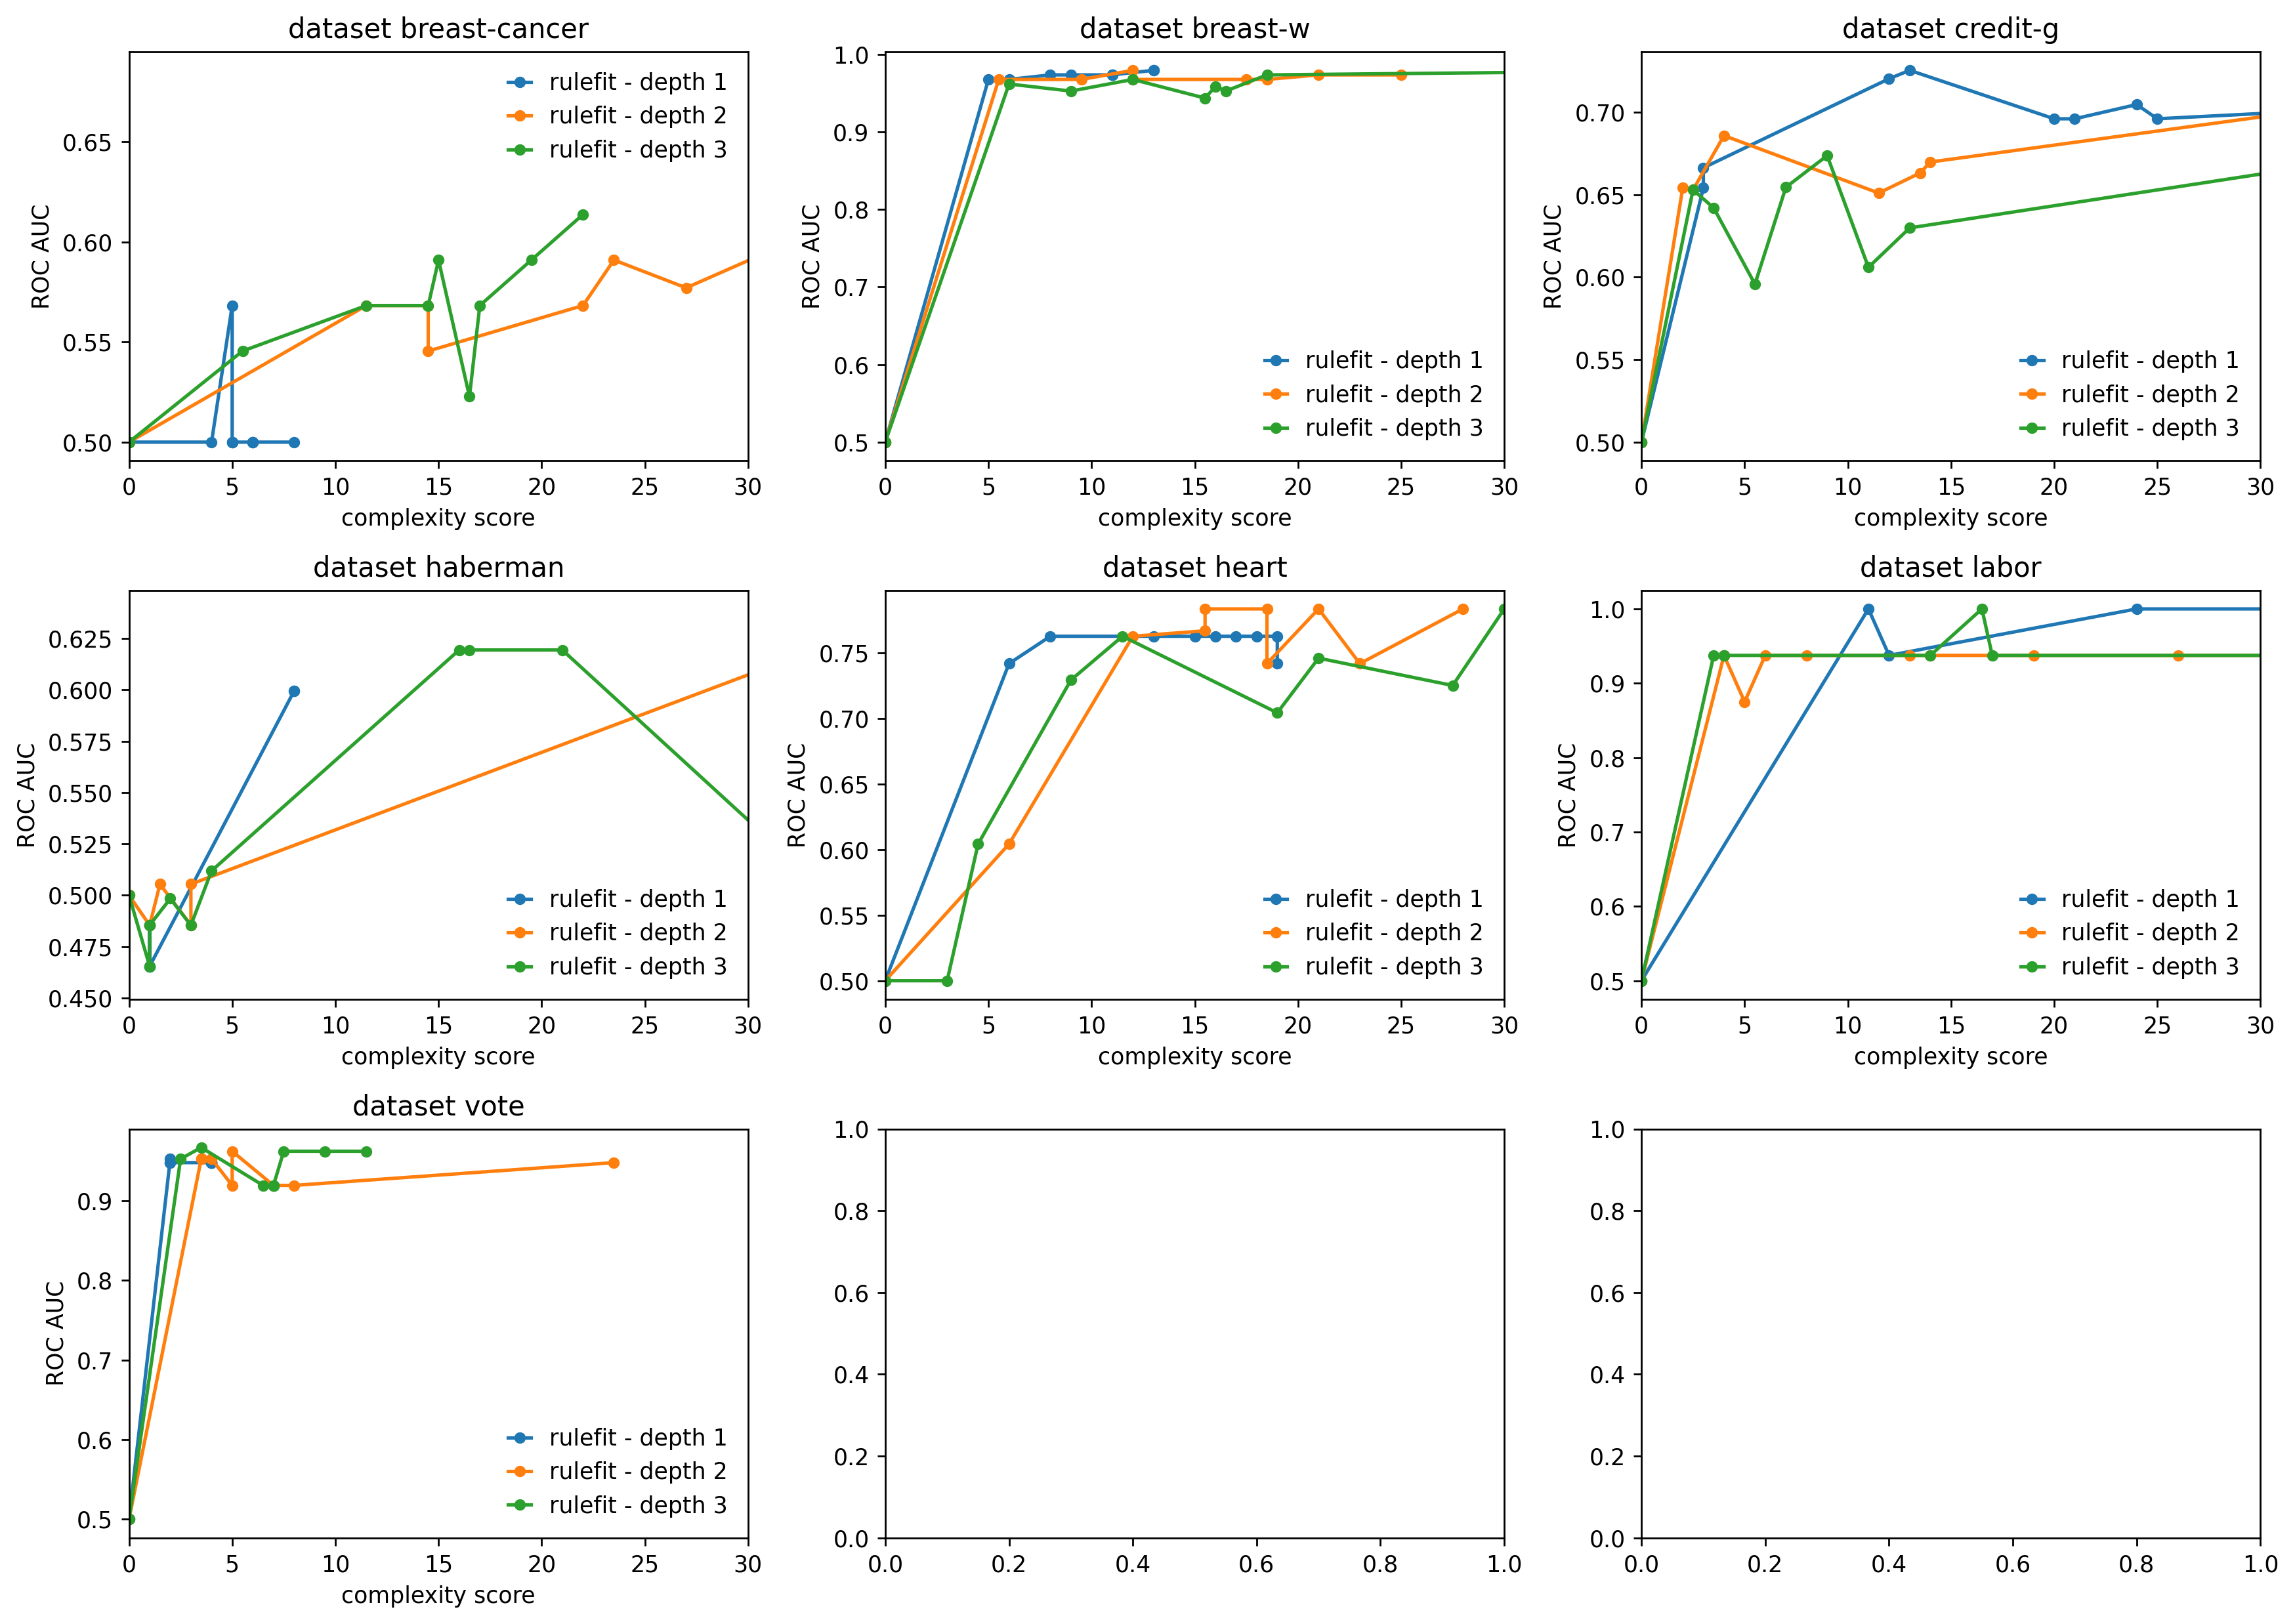

In [8]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'rulefit')
viz_comparison_val_average(comparison_result)
viz_comparison_datasets(comparison_result)

## FPLasso

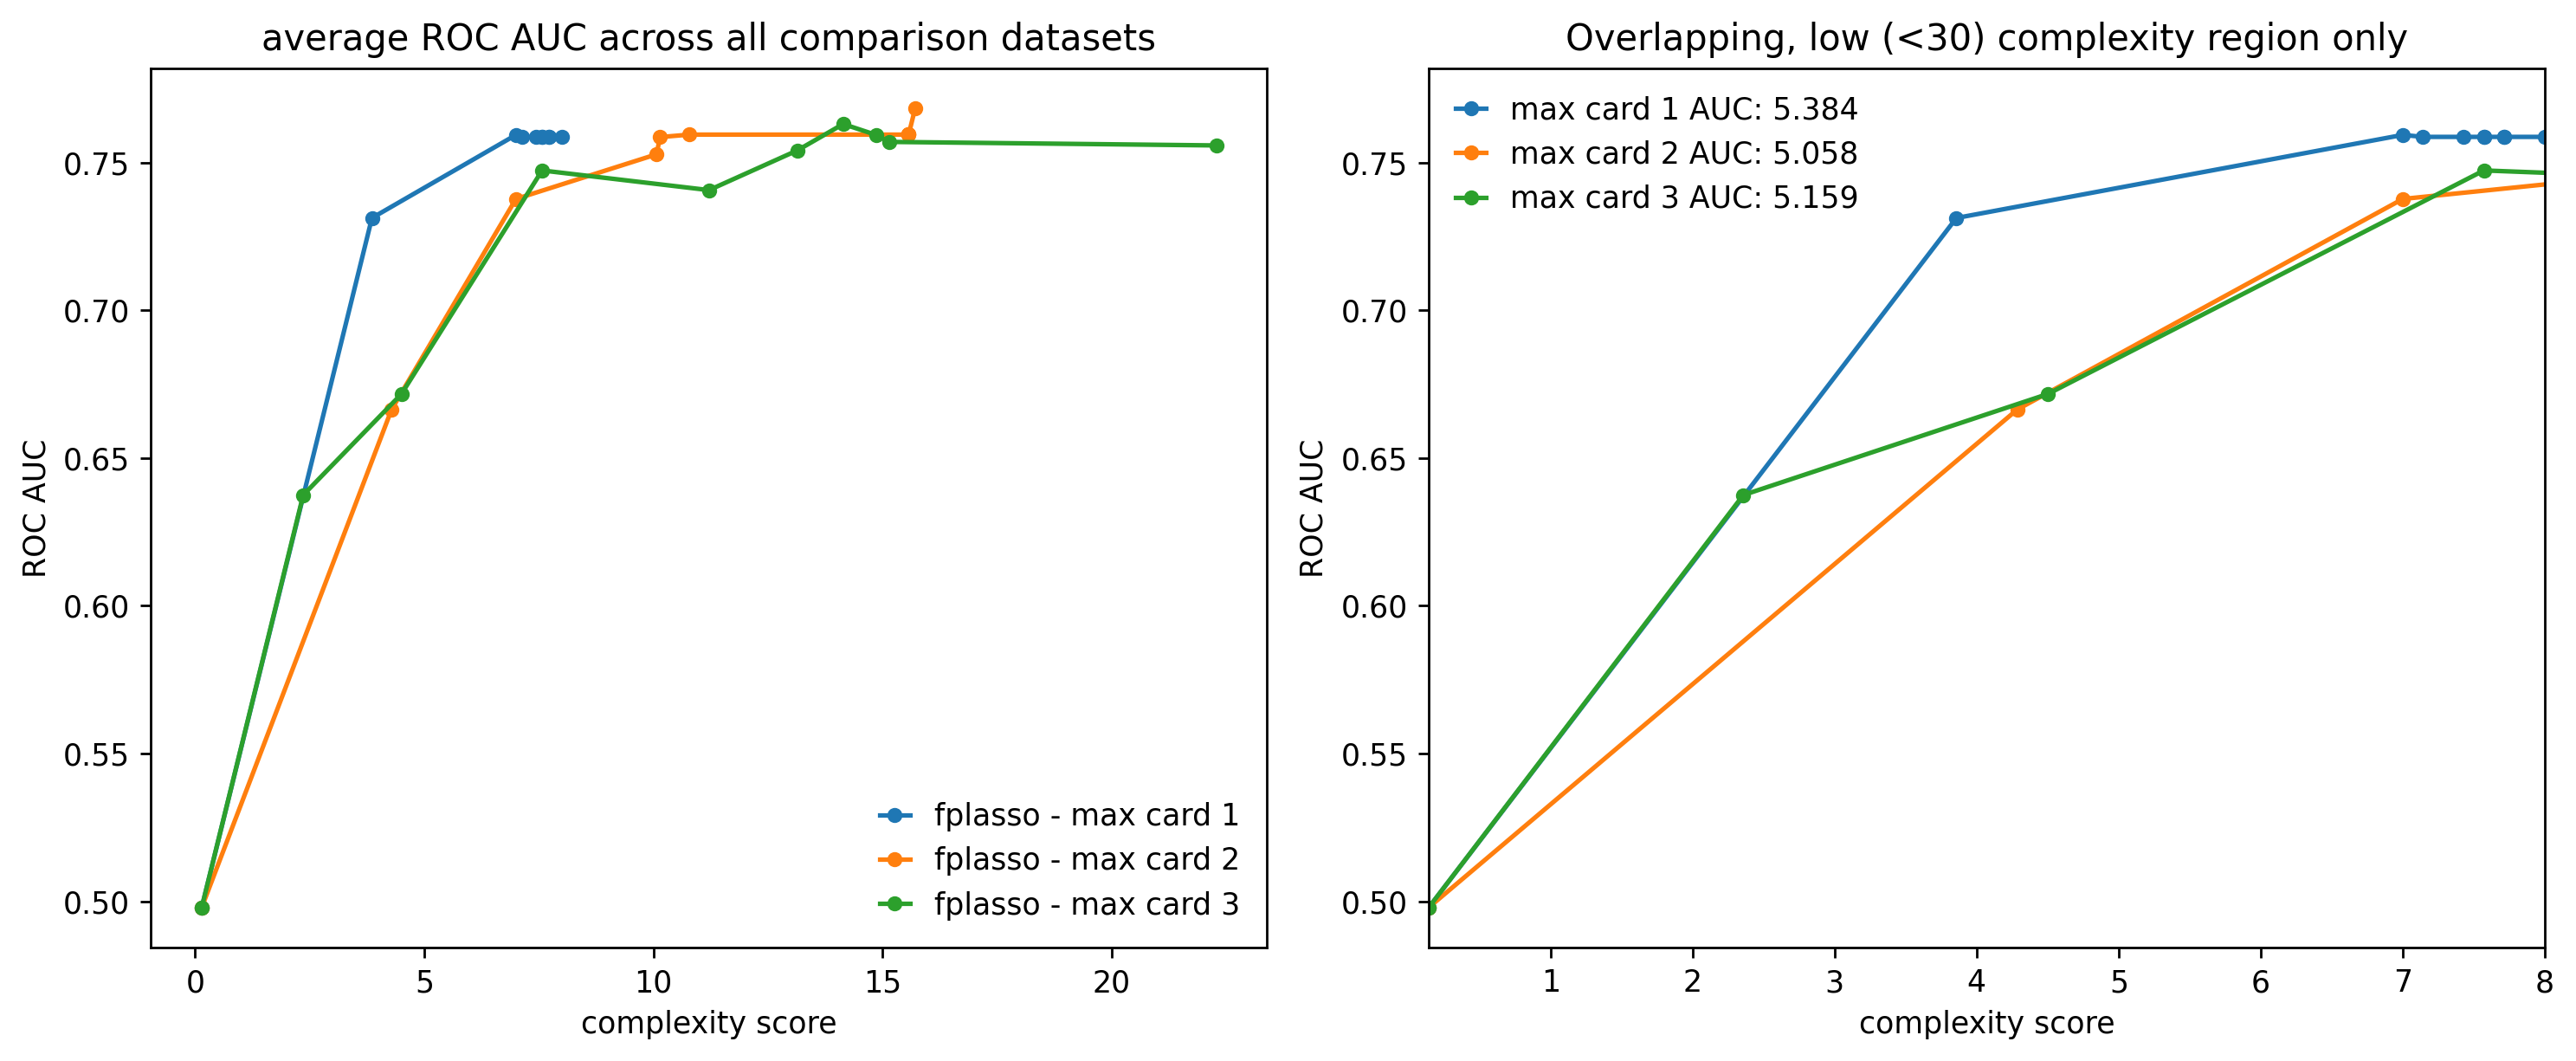

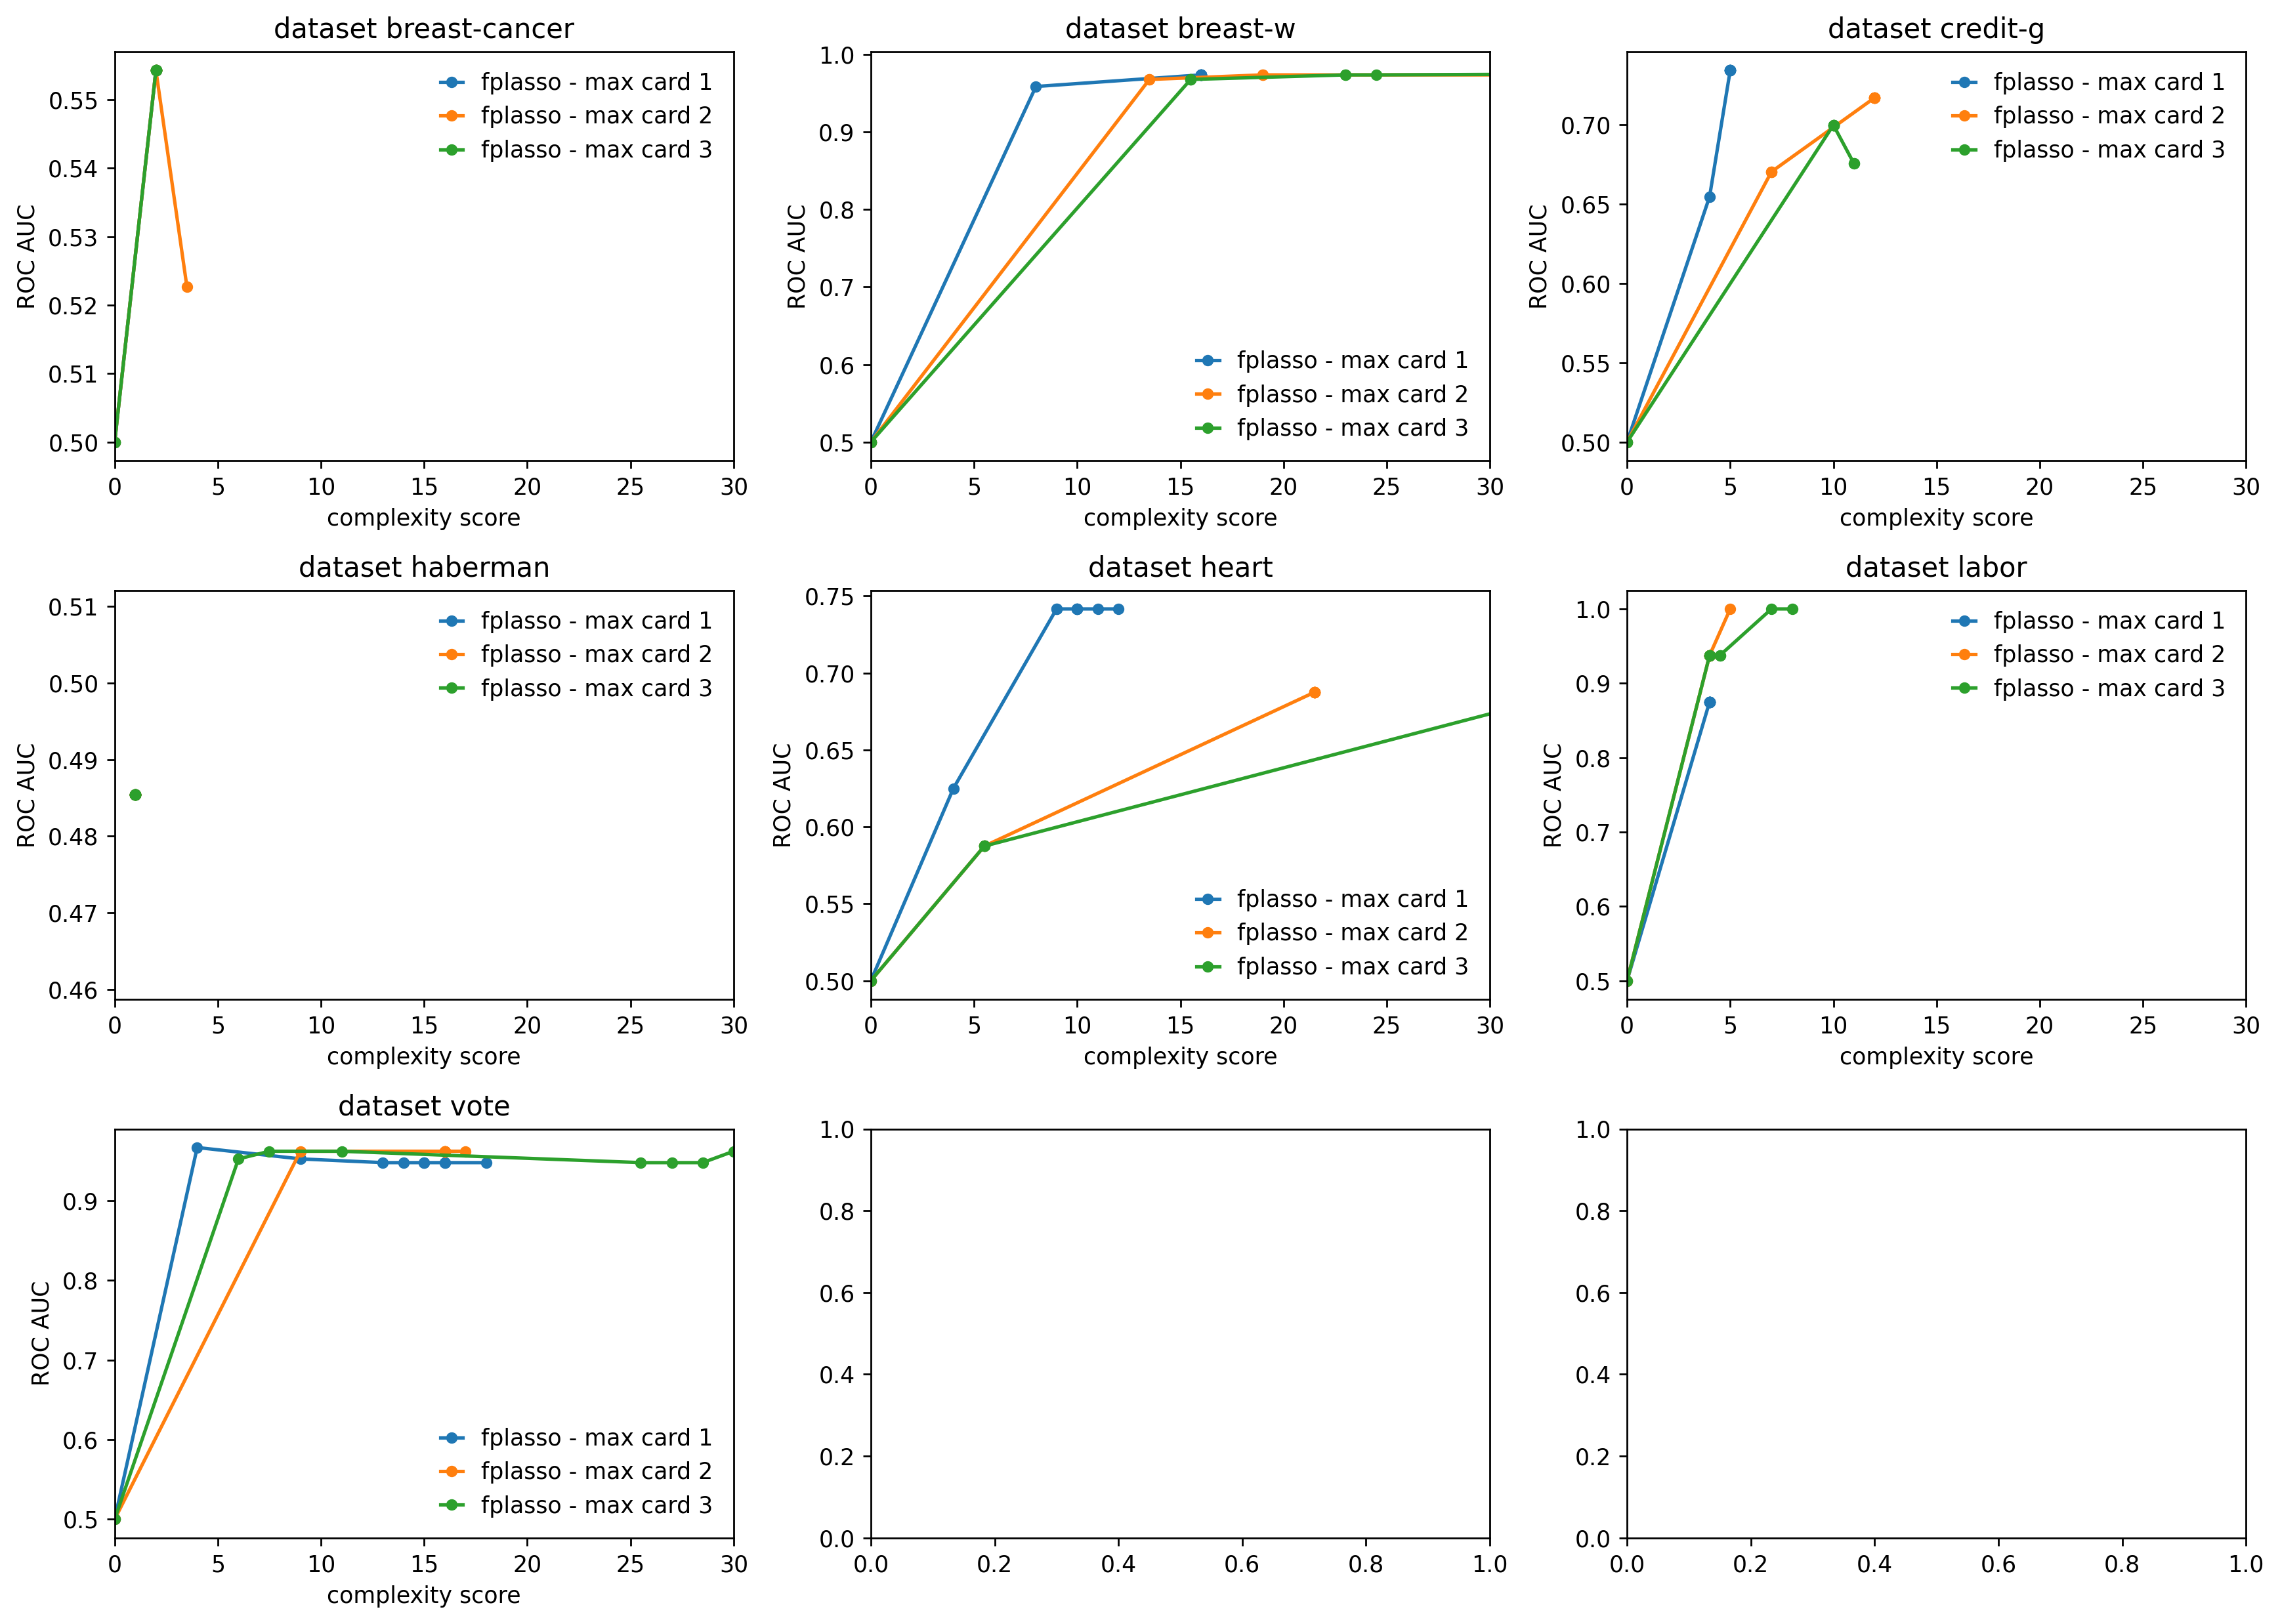

In [9]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'fplasso')
viz_comparison_val_average(comparison_result)
viz_comparison_datasets(comparison_result)

## FPSkope

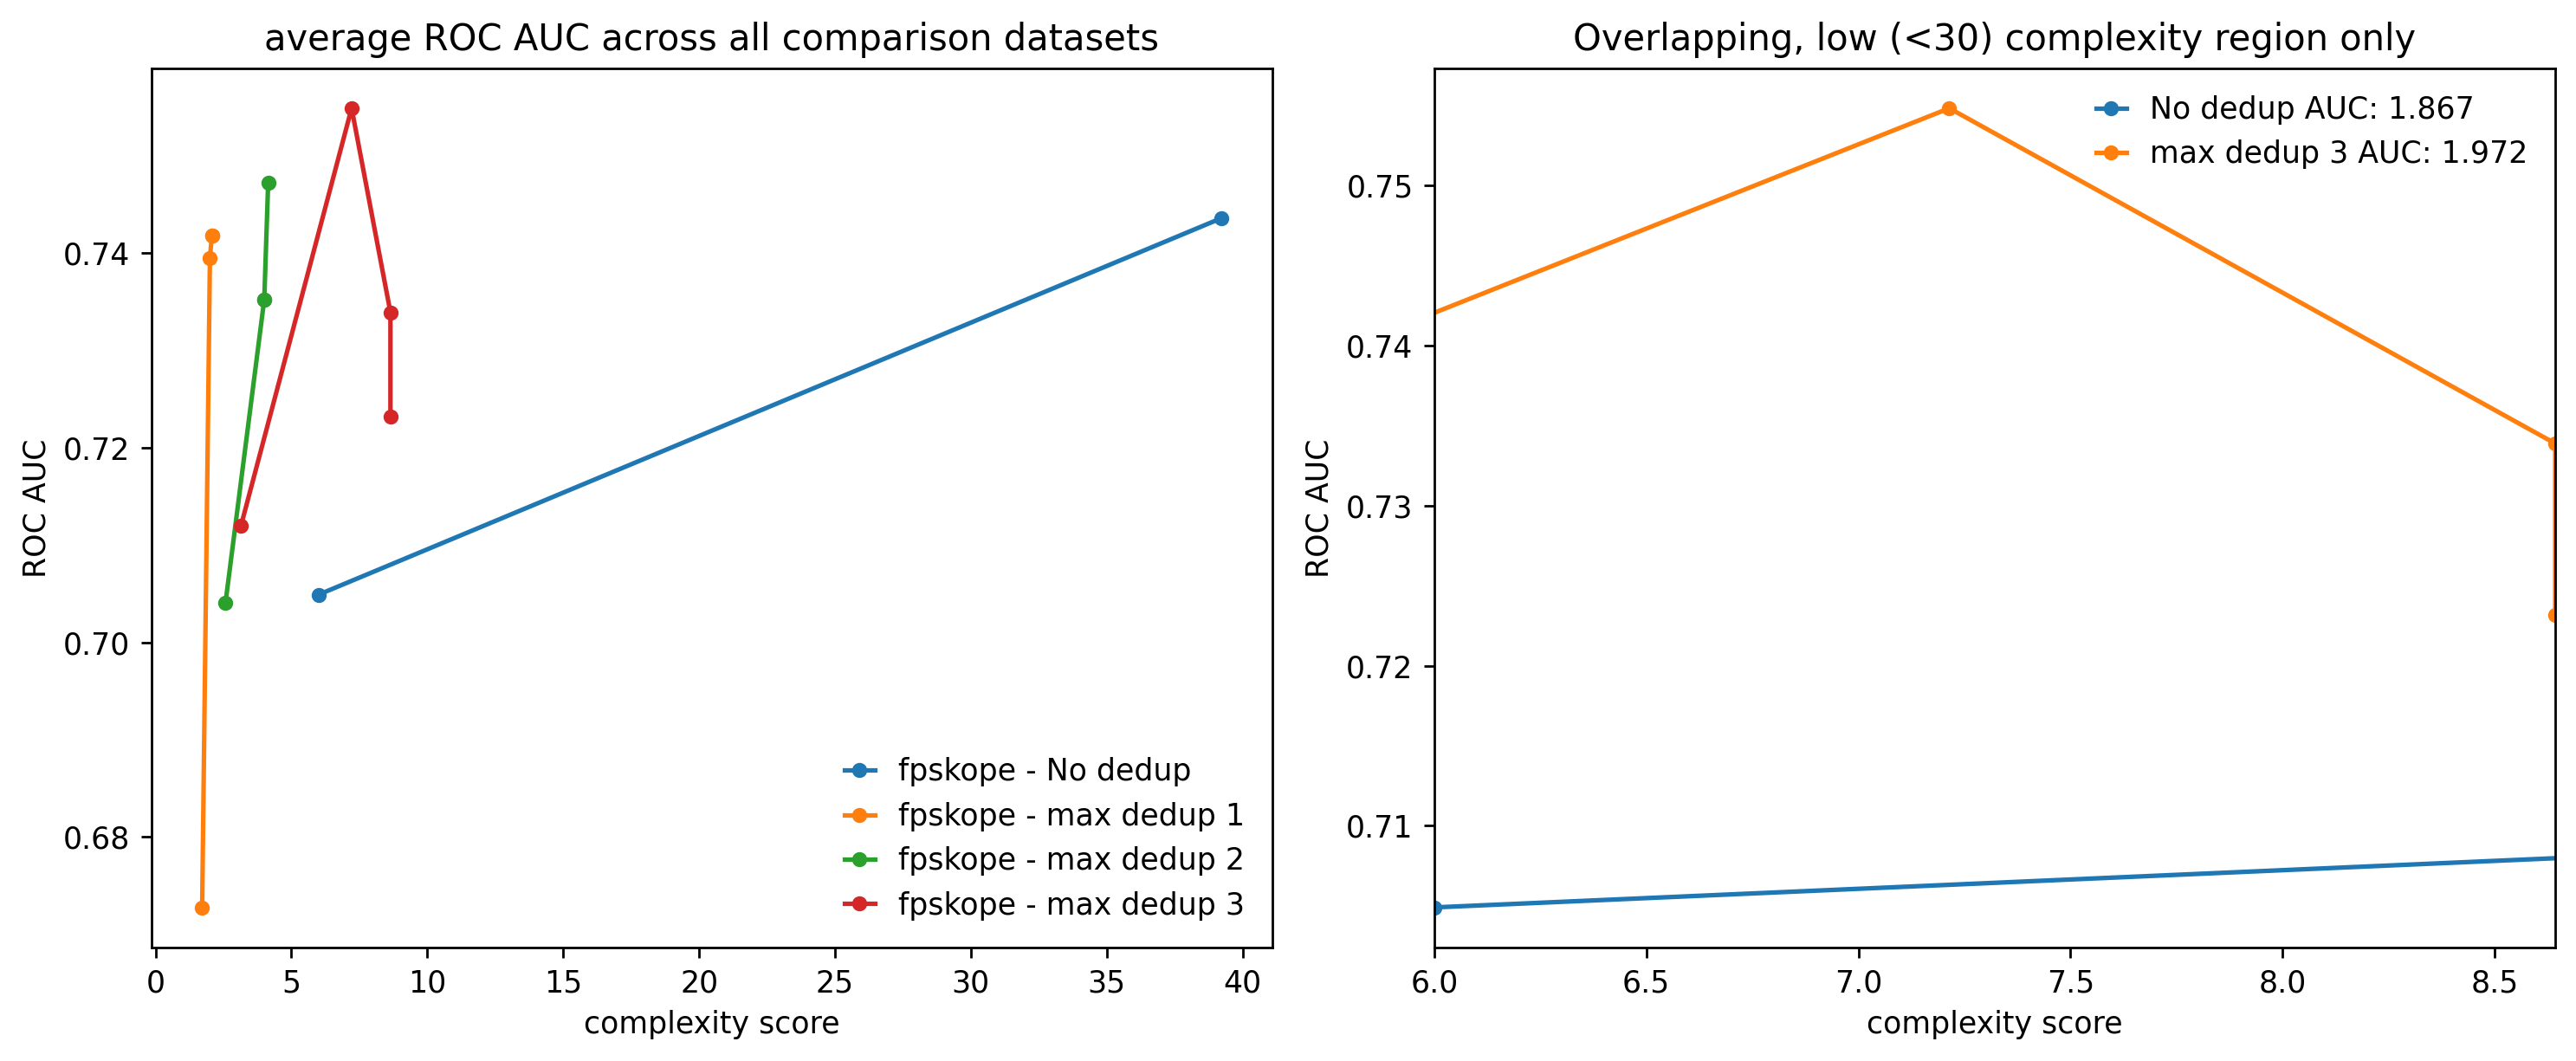

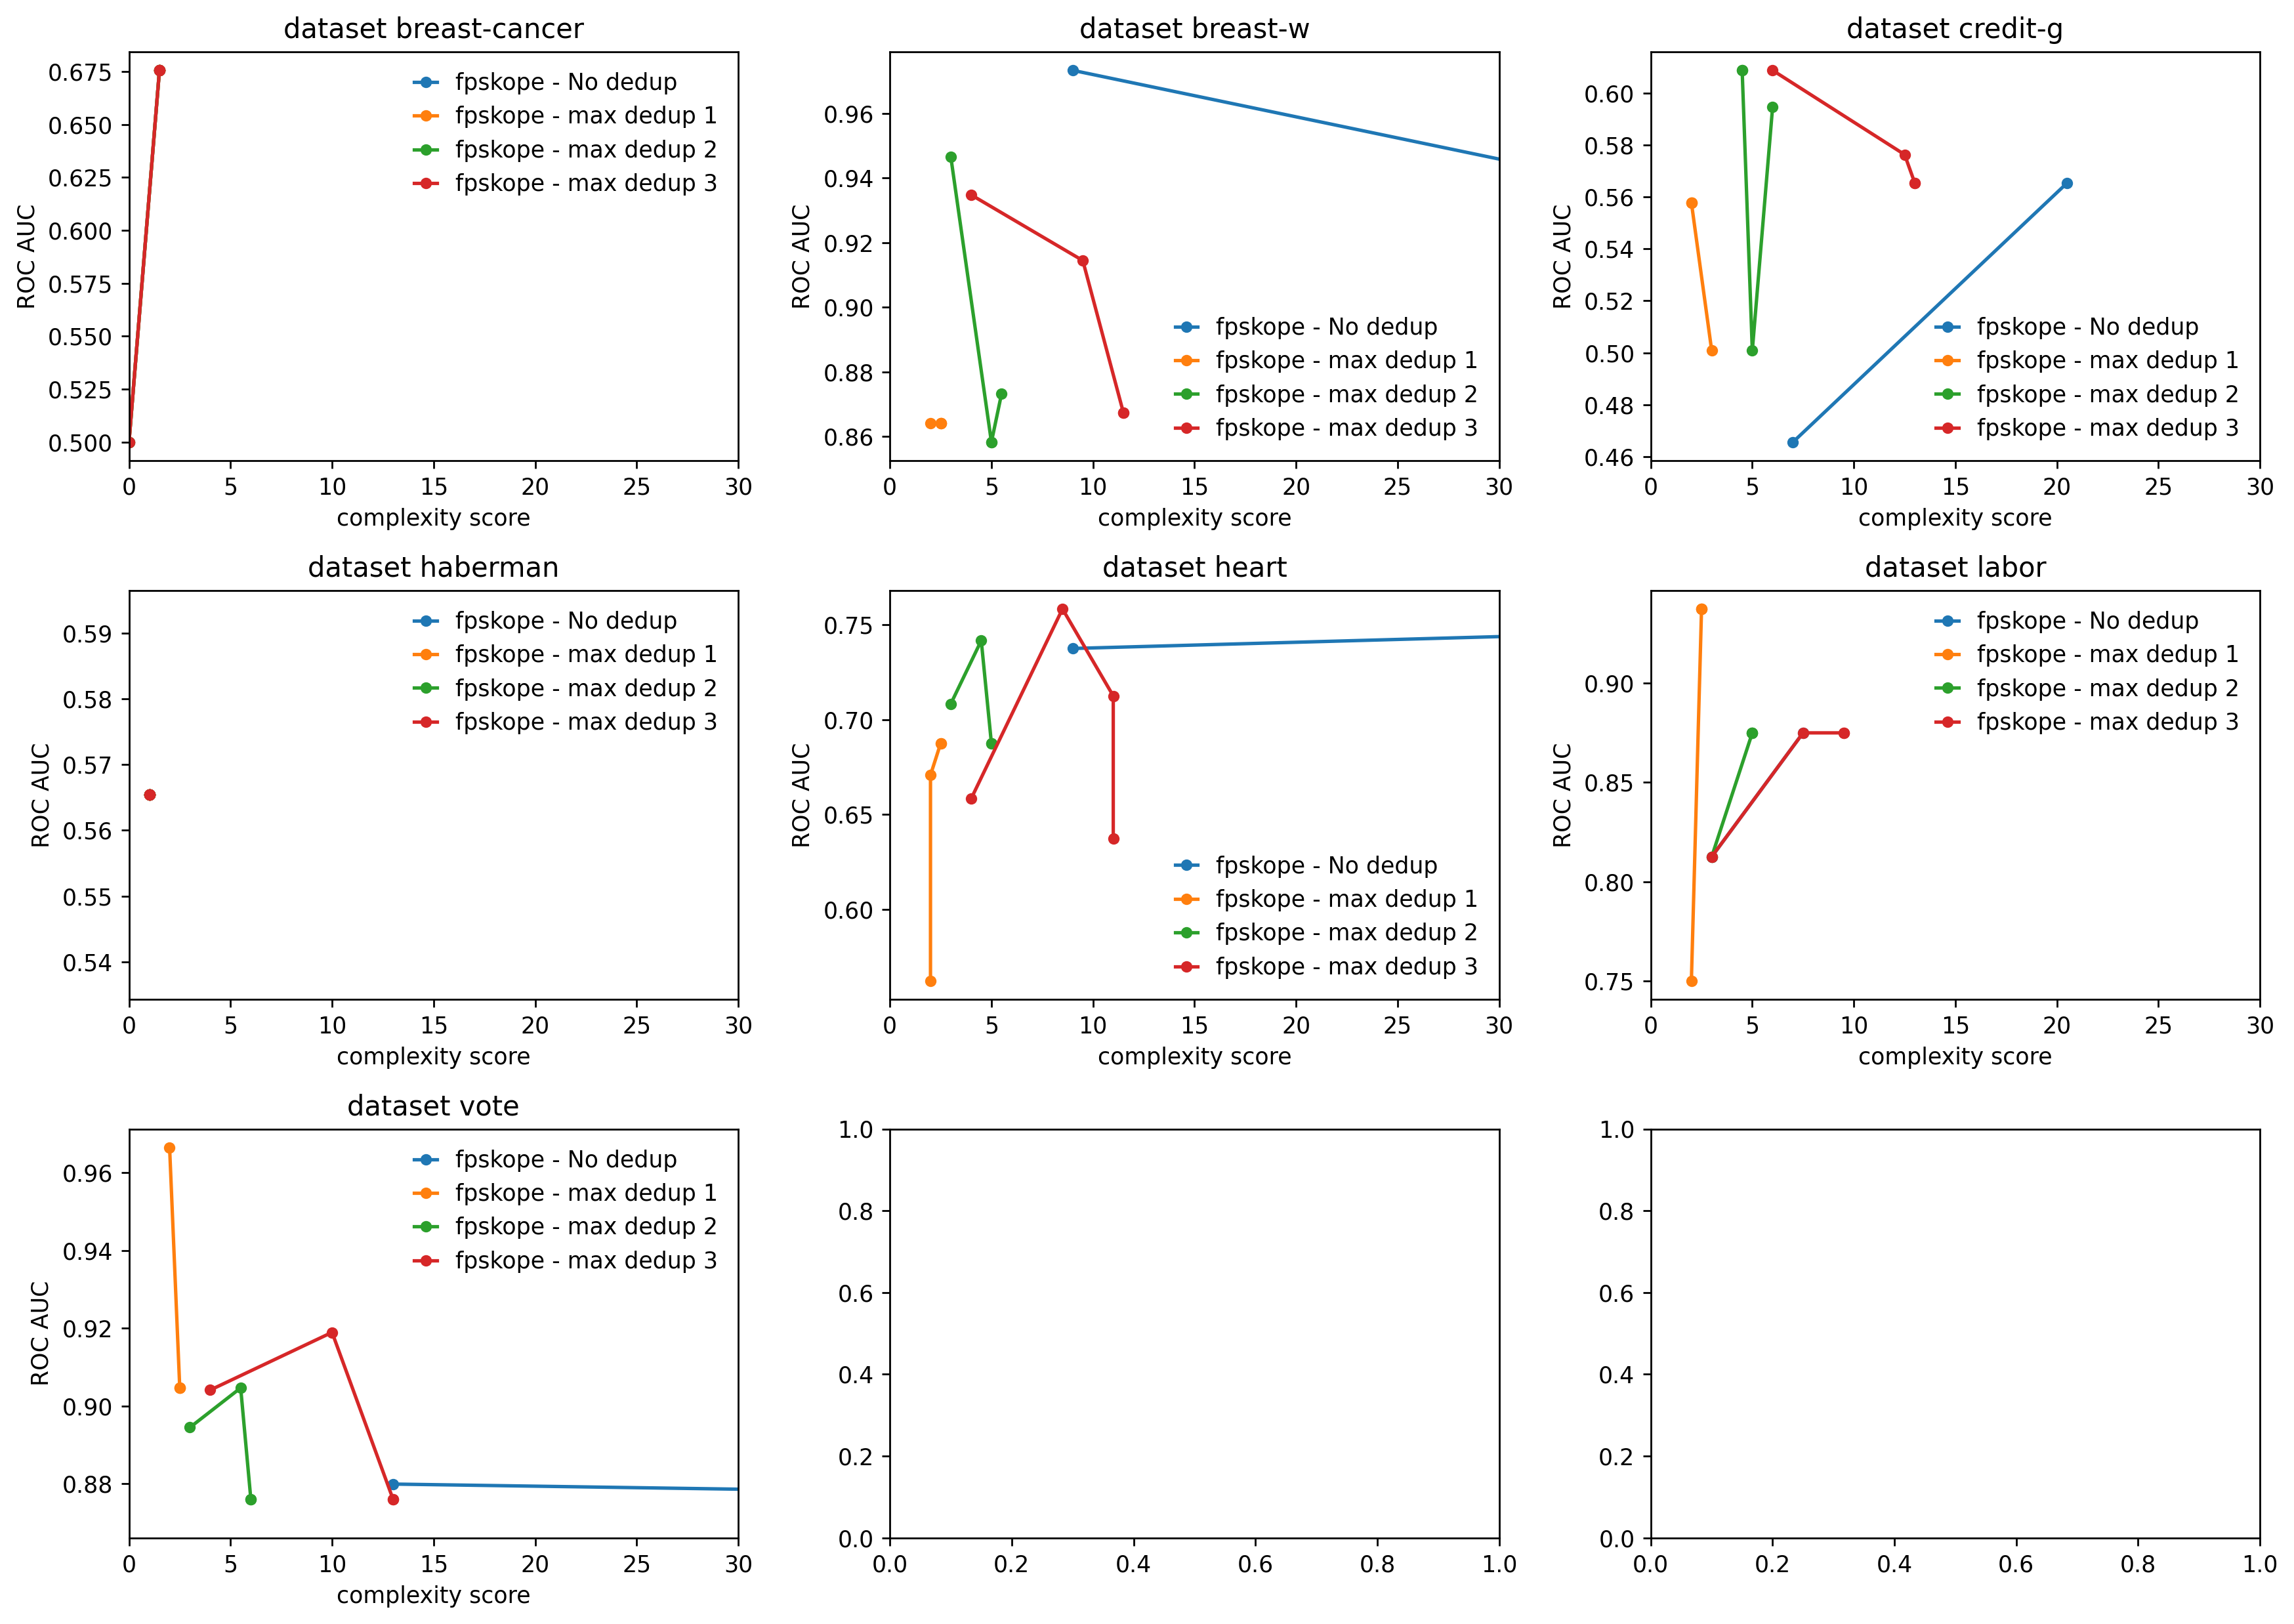

In [10]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'fpskope')
viz_comparison_val_average(comparison_result)
viz_comparison_datasets(comparison_result)

## BRL

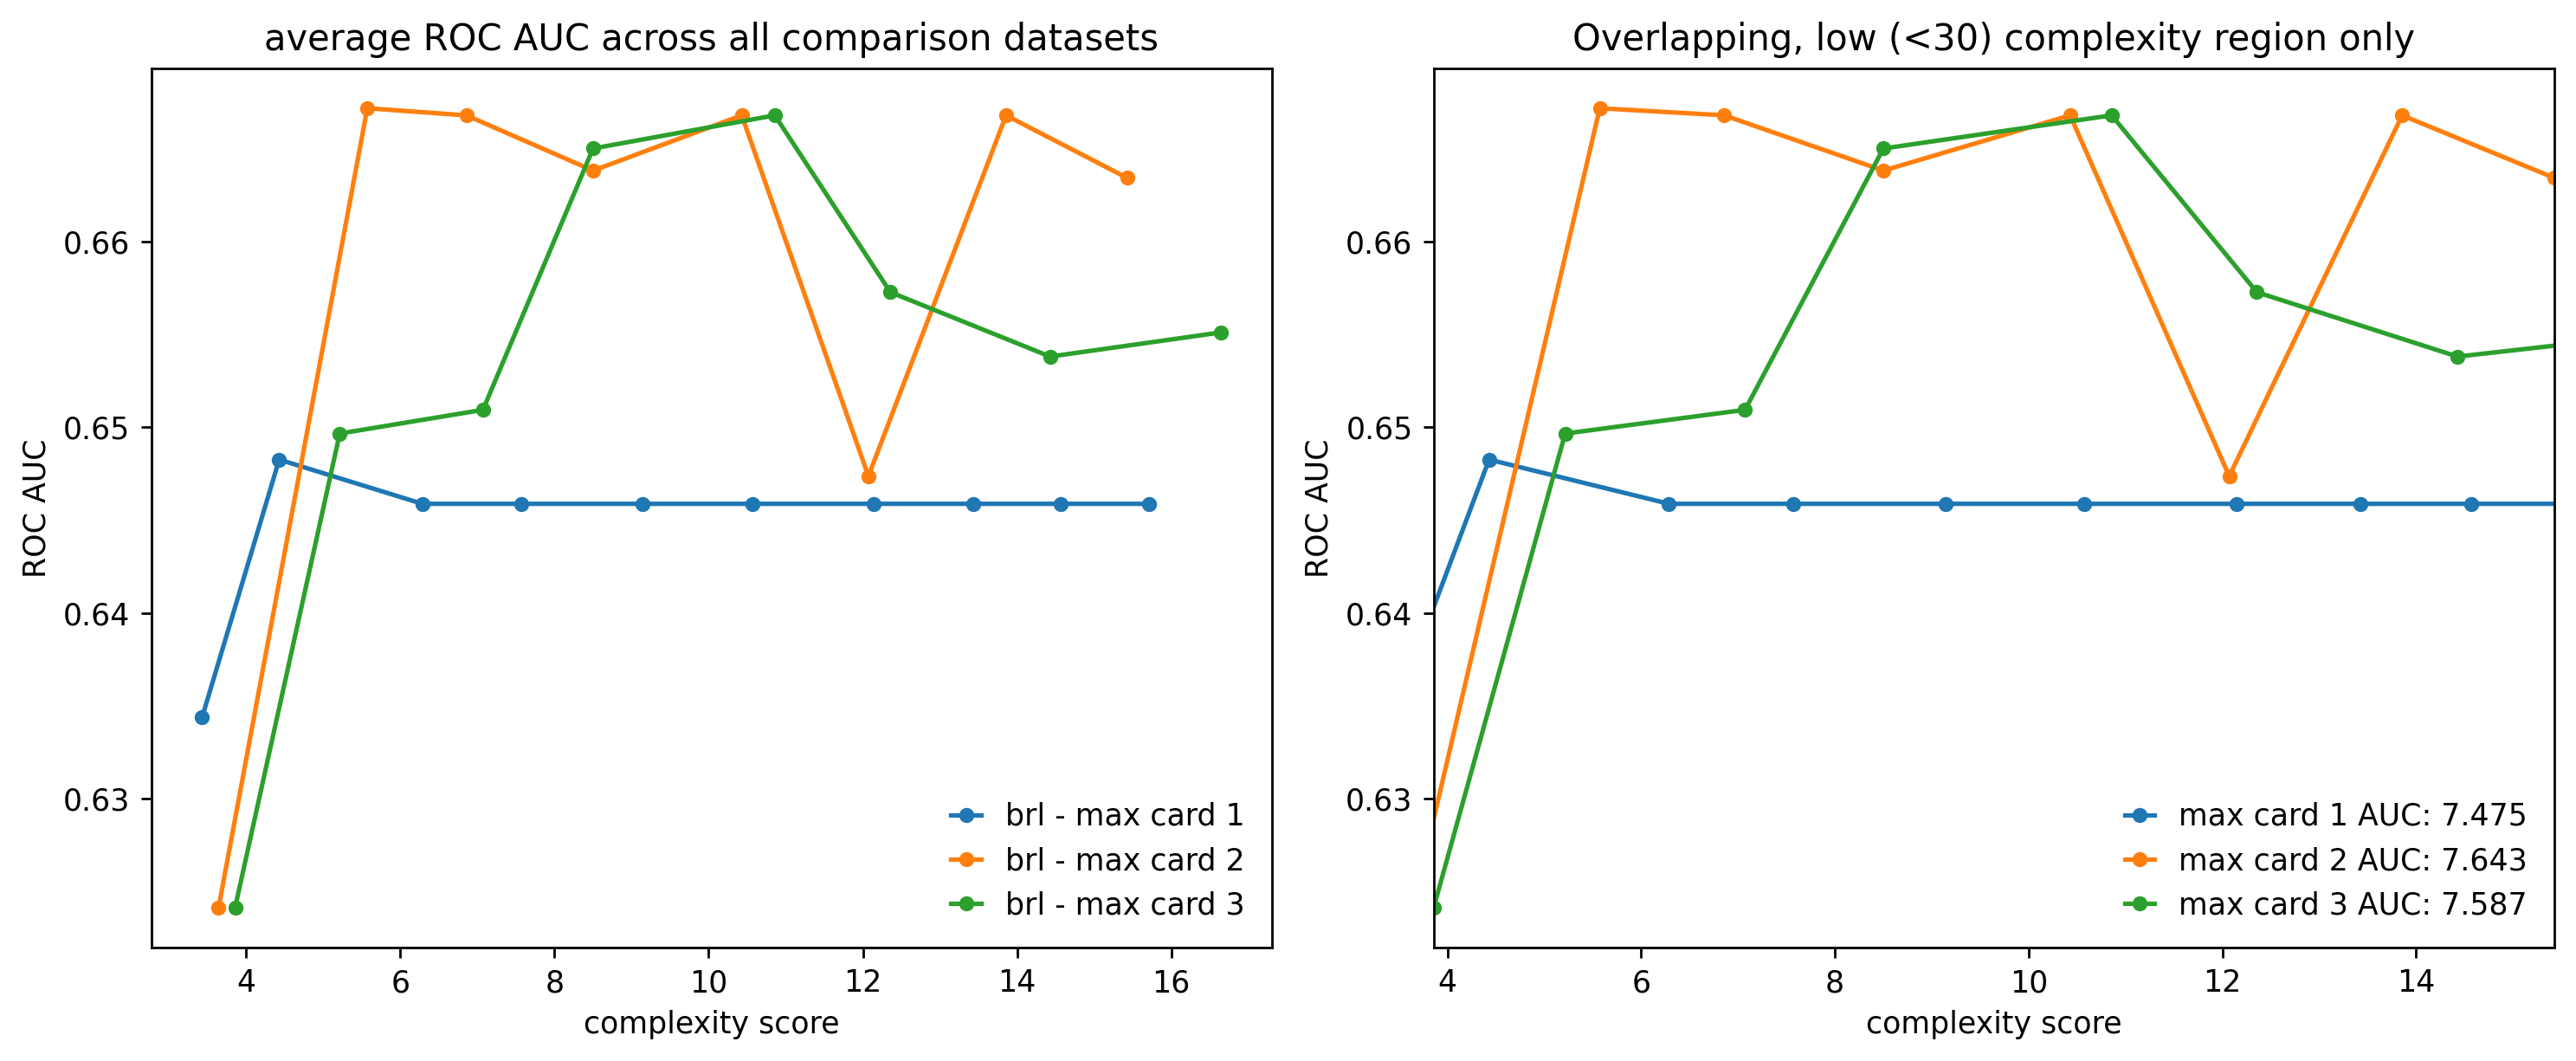

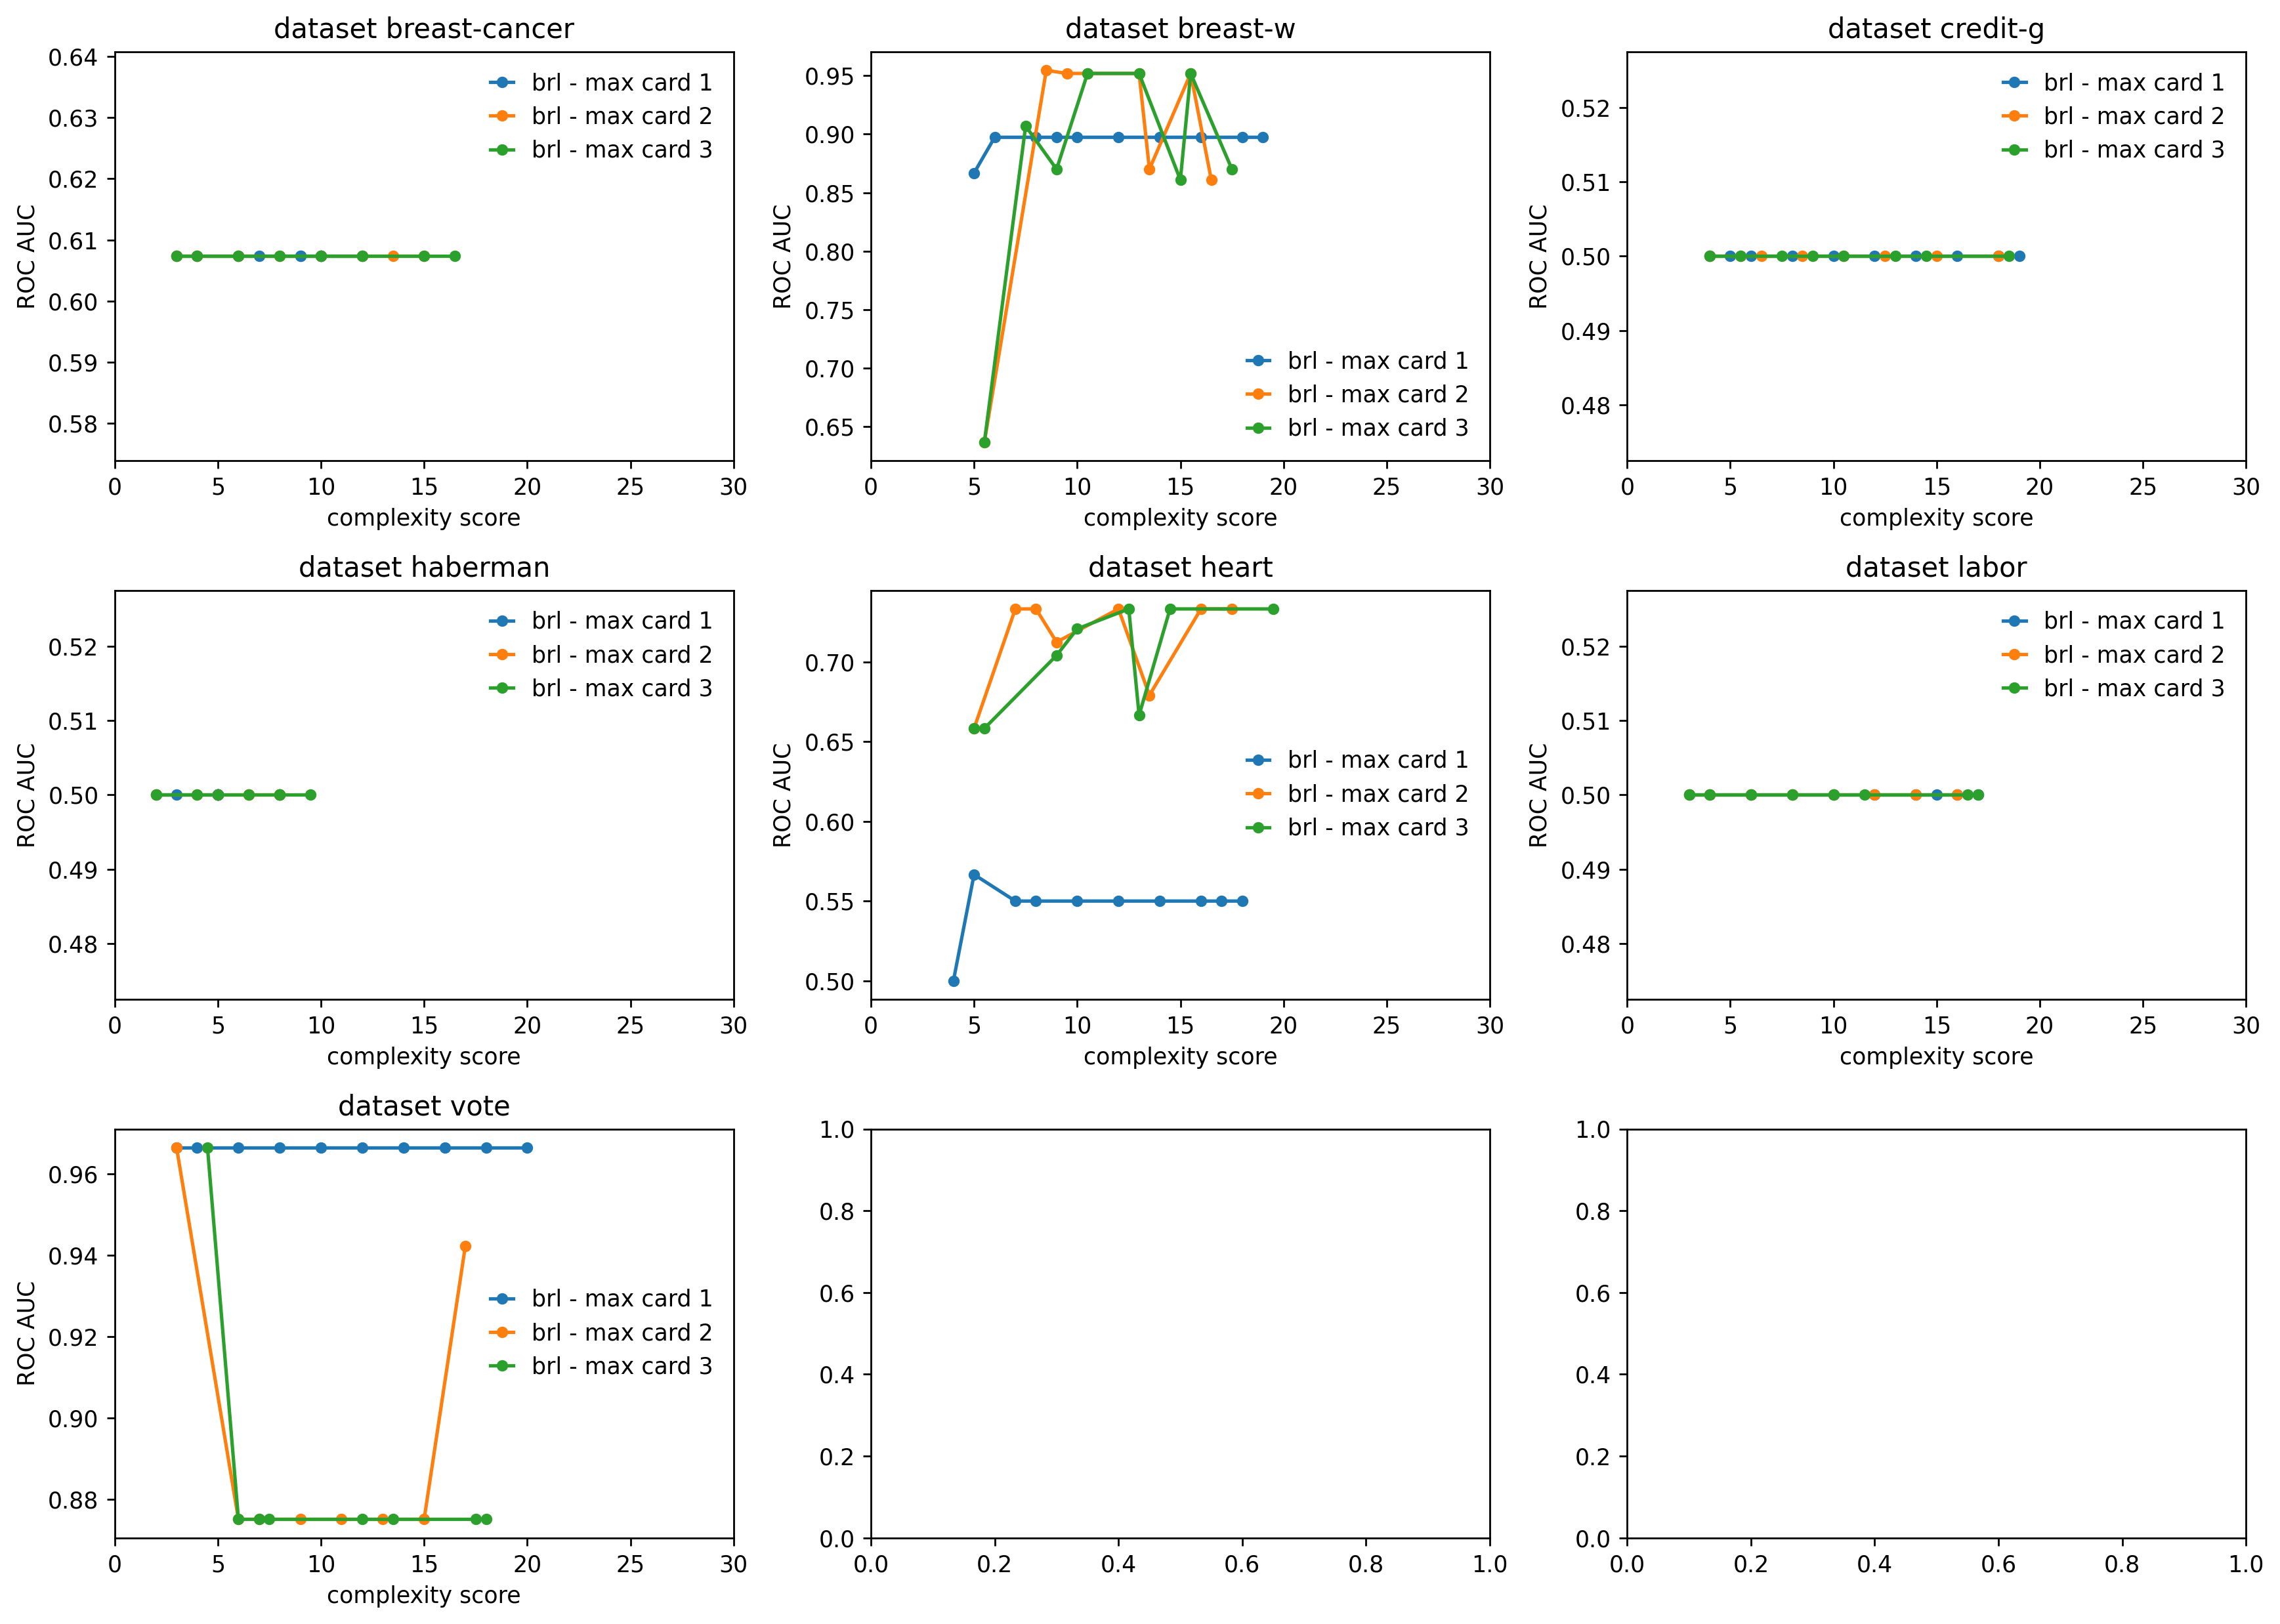

In [11]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'brl')
viz_comparison_val_average(comparison_result)
viz_comparison_datasets(comparison_result)